In [1]:
import cytoflow as flow
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import glob
import numpy as np
import pandas as pd
import matplotlib.colors as colors
from scipy import optimize
from scipy.optimize import curve_fit, minimize


darks=['#3a80b0', '#ff7200', '#984ea3', '#7fc97f',  '#e261b0']
pastels=['#b3cde3','#fed9a6','#decbe4','#ccebc5',  '#f4cae4']
superdarks=['#1f5a82', '#ee4e00', '#771e85', '#41ab5d', '#cf3092']


greys=['#252525','#525252','#737373','#969696']
blues=[superdarks[0], darks[0], '#5b97c0', pastels[3]] 
oranges=[superdarks[1], darks[1],  '#ffa55d', pastels[0]] 
purples=[superdarks[2], darks[2], '#b981c2', pastels[1]]
greens=[superdarks[3], darks[3], '#a7dda7', pastels[2]]
pinks=[superdarks[4], darks[4], '#ea93c8', pastels[4]]


plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

In [2]:
#functions for importing fcs data

def import_fcs_files(path, sample_list, names_in):
    files=glob.glob(path)
    print(len(files))   
    
    samples=[]
    for f in files: 
        well=f[-7:-4]
        #print(well)
        name=sample_list[sample_list['well']==well]['sample'].reset_index(drop=True)[0]
        #print(name)
        if name in names_in:
            #print(name)
            sample=flow.Tube(file=f, conditions={'name':name})
            samples.append(sample) 
    expout=flow.ImportOp(tubes=samples, conditions={'name':'category'}).apply()
    return(expout)


#functions for logicle

def get_p(W, guess=1):
    #Calculates p for a given value for W. Needed for the logicle function since
    #the function uses p as a internal variable that is wholly dependent on W.
    root = lambda p, W : 2 * p * np.log10(p) / (p + 1) - W
    return optimize.root(root, guess, args=(W)).x[0]

def half_logicle(X, W, T, M=4.5):
    #Calculates the logicle function for values of X >= W. For a given x-axis
    #location, X, this function determines what the corresponding fluorescence,
    #which is later named S, should be at that location.
    p = get_p(W)
    k = T * 10 ** (-(M - W))
    a = 10 ** (X - W)
    b = p ** 2 * 10 ** (-(X - W) / p)
    c = p ** 2
    return np.array(k * (a - b + c - 1))

def logicle_fxn(X, W, T, M=4.5):
    #Defines the logicle for all X >= 0. The logicle function is supposed to be
    #symmetric around X = W, so this function adds in the negative symmetrical
    #part for when X < W.
    condlist = [X < W, X >= W]
    choicelist = [-half_logicle(W + (W - X), W, T, M), half_logicle(X, W, T, M)]
    return np.select(condlist, choicelist)


96
0.6028353817379668
262144.0
4.5


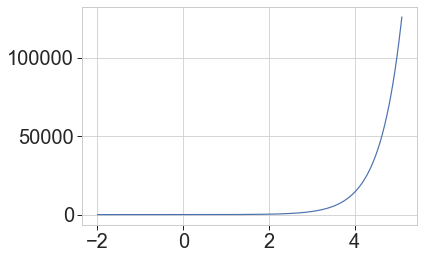

In [4]:
# import default experiment for logicle scaling
# run this block before making any plots using a logicle scale
# used to set logicle scale
# ensures all plots using the logicle axis are on the same scale


rep1_plate1_samples=pd.read_csv('flow_fig3_rep1\plate_1\sample_list.csv', names=['well', 'sample'])
# print(rep1_plate1_samples)

names_in=['1A976','400_1', '400_4']
log_exp=import_fcs_files('flow_fig3_rep1\plate_1\*.fcs', rep1_plate1_samples, names_in)
log_exp.data

# get logicle scale 

logicle=flow.utility.scale_factory('logicle', log_exp, channel='FITC-A')
logicle

W=logicle._get_W()
print(W)

T=logicle._get__T()
print(T)

M=logicle.M 
print(M) 

# should be
# W=0.6028353817379668
# T=262144.0
# M=4.5


x = np.linspace(-2, 5.1, 300)
bins_logicle = logicle_fxn(x, W, T)
bins_log = 10 ** np.linspace(-1, 5.1, 300)


In [9]:
#import fcs data to make fig 3
#keep plates and replicates separate to make things run faster

rep1_plate1_samples=pd.read_csv('flow_fig3_rep1\plate_1\sample_list.csv', names=['well', 'sample'])
rep1_plate2_samples=pd.read_csv('flow_fig3_rep1\plate_2\sample_list.csv', names=['well', 'sample'])


rep2_plate1_samples=pd.read_csv('flow_fig3_rep2\plate_1\sample_list.csv', names=['well', 'sample'])
rep2_plate2_samples=pd.read_csv('flow_fig3_rep2\plate_2\sample_list.csv', names=['well', 'sample'])


rep3_plate1_samples=pd.read_csv('flow_fig3_rep3\plate_1\sample_list.csv', names=['well', 'sample'])
rep3_plate2_samples=pd.read_csv('flow_fig3_rep3\plate_2\sample_list.csv', names=['well', 'sample'])

#names based on original plasmid #'s and not names in the paper
names=['400_1', '400_4', '400G_1', '400G_4', # 400 = +SEQ1,'_1' is 800pM DNA and '_4' is 0pM DNA (for all)
        '570_1', '570_4', '571_1', '571_4', '572_1', '572_4', '573_1', '573_4', 'A_on', # 570-573 are +SEQ1 animal homologs
       '402_1', '402_4', '402C_1', '402C_4', #402=+SEQ2
        '574_1', '574_4', 'C_on', #574=+SEQ2 animal homologs, C_on is SEN2del(DT)
       '403_1', '403_4', '403G_1', '403G_4', #403= +SEQ3
        '575_1', '575_4', '576_1', '576_4', 'D_on', #575, 576 = +SEQ3 animal homologs, D_on is SEN3del(DT)
       '404_1', '404_4', '404G_1', '404G_4', '404T_1', '404T_4', #404 = +SEQ4
        '577_1', '577_4', '578_1', '578_4', 'E_on', #577, 578 = +SEQ4 animal homologs, E_on is SEN4del(DT)
       '405_1', '405_4', '405A_1', '405A_4', 'F_on', '1A976'] #405 =+SEQ5, F_ON is SEN5del(DT)


names2=['400_2', '400_3', '400G_2', '400G_3', #same as above, except '_2'=80pM and '_3'=8pM
        '570_2', '570_3', '571_2', '571_3', '572_2', '572_3', '573_2', '573_3',
       '402_2', '402_3', '402C_2', '402C_3',
        '574_2', '574_3', 
       '403_2', '403_3', '403G_2', '403G_3',
        '575_2', '575_3', '576_2', '576_3', 
       '404_2', '404_3', '404G_2', '404G_3', '404T_2', '404T_3',
        '577_2', '577_3', '578_2', '578_3', 
       '405_2', '405_3', '405A_2', '405A_3']



r1p1_path='flow_fig3_rep1\plate_1\*.fcs'
r1p2_path='flow_fig3_rep1\plate_2\*.fcs'
r2p1_path='flow_fig3_rep2\plate_1\*.fcs'
r2p2_path='flow_fig3_rep2\plate_2\*.fcs'
r3p1_path='flow_fig3_rep3\plate_1\*.fcs'
r3p2_path='flow_fig3_rep3\plate_2\*.fcs'



r1p1=import_fcs_files(r1p1_path, rep1_plate1_samples, names)
r1p2=import_fcs_files(r1p2_path, rep1_plate2_samples, names)

r2p1=import_fcs_files(r2p1_path, rep2_plate1_samples, names)
r2p2=import_fcs_files(r2p2_path, rep2_plate2_samples, names)

r3p1=import_fcs_files(r3p1_path, rep3_plate1_samples, names)
r3p2=import_fcs_files(r3p2_path, rep3_plate2_samples, names)

print(r1p1.data.groupby(by='name').size())
print(r1p2.data.groupby(by='name').size())

print(r2p1.data.groupby(by='name').size())
print(r2p2.data.groupby(by='name').size())

print(r3p1.data.groupby(by='name').size())
print(r3p2.data.groupby(by='name').size())



r1p1_2=import_fcs_files(r1p1_path, rep1_plate1_samples, names2)
r1p2_2=import_fcs_files(r1p2_path, rep1_plate2_samples, names2)

r2p1_2=import_fcs_files(r2p1_path, rep2_plate1_samples, names2)
r2p2_2=import_fcs_files(r2p2_path, rep2_plate2_samples, names2)

r3p1_2=import_fcs_files(r3p1_path, rep3_plate1_samples, names2)
r3p2_2=import_fcs_files(r3p2_path, rep3_plate2_samples, names2)

print(r1p1_2.data.groupby(by='name').size())
print(r1p2_2.data.groupby(by='name').size())

print(r2p1_2.data.groupby(by='name').size())
print(r2p2_2.data.groupby(by='name').size())

print(r3p1_2.data.groupby(by='name').size())
print(r3p2_2.data.groupby(by='name').size())

96
76
96
76
82
90
name
405_3     500000
404T_2    500000
404_2     500000
403_2     500000
577_2     500000
402C_2    500000
400_2     500000
571_2     500000
402_2     500000
576_2     500000
403G_2    500000
405_2     500000
576_3     500000
404T_3    500000
400G_2    500000
405A_2    500000
402_3     500000
571_3     500000
403_3     500000
572_2     500000
400_3     500000
dtype: int64
name
575_3     500000
403G_3    500000
405A_3    500000
578_3     500000
400G_3    500000
574_3     500000
573_2     500000
404_3     500000
575_2     500000
404G_2    500000
570_2     500000
574_2     500000
577_3     500000
404G_3    500000
578_2     500000
572_3     500000
402C_3    500000
570_3     500000
573_3     500000
dtype: int64
name
405_3     500000
404T_2    500000
404_2     500000
403_2     500000
577_2     500000
402C_2    500000
400_2     500000
571_2     500000
402_2     500000
576_2     500000
403G_2    500000
405_2     500000
576_3     500000
404T_3    500000
400G_2    500000
405A_2

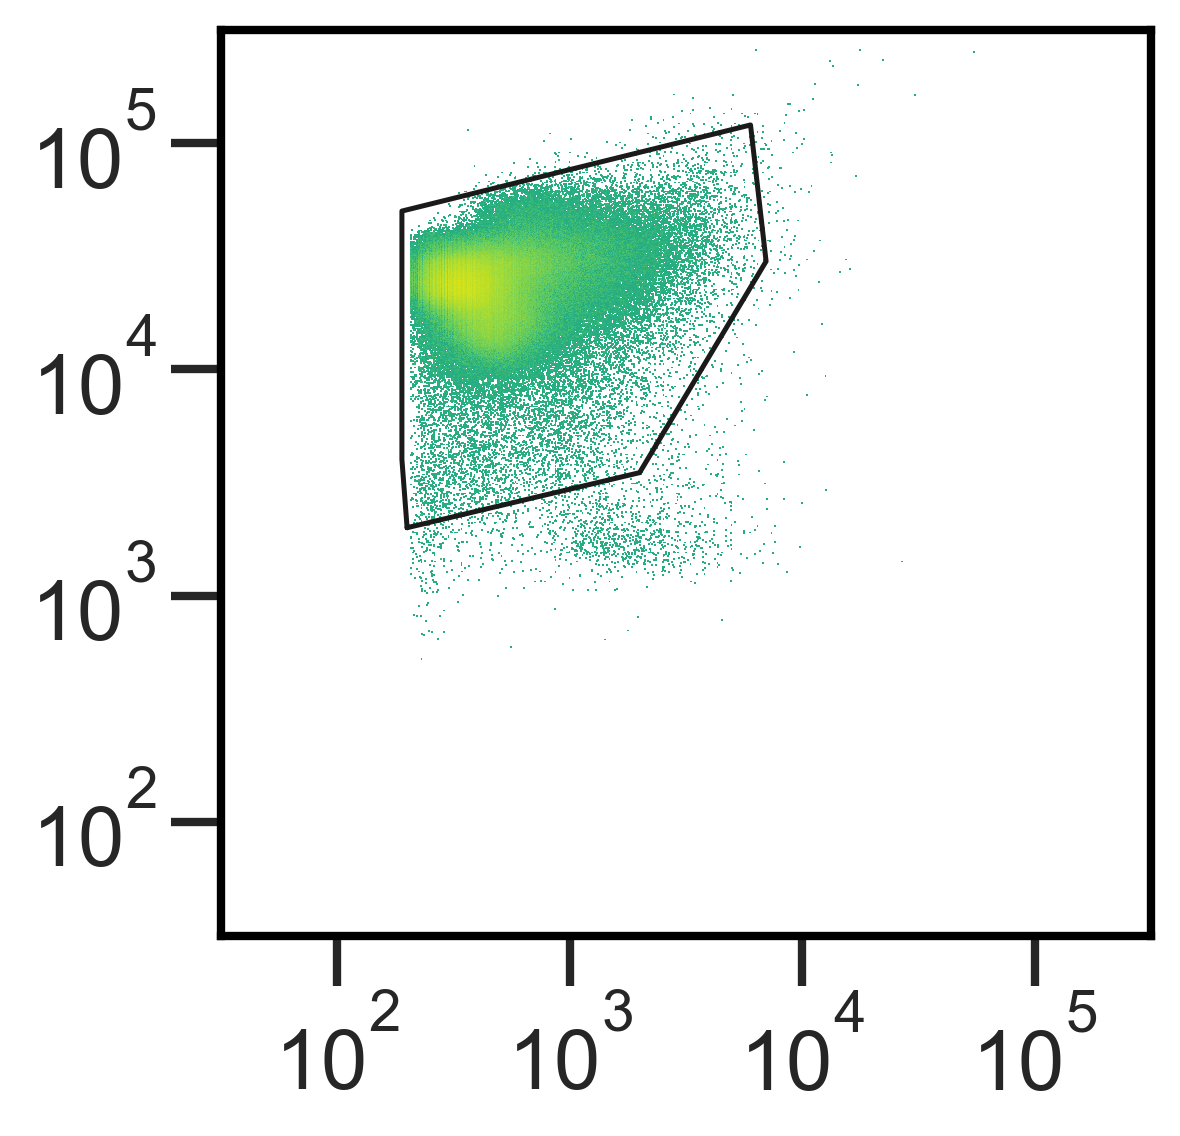

In [6]:
# code to generate FSC vs SSC plots
# supplementary figure ### uses sample r1p1.data.loc[r1p1.data['name']=='400_1']

xbins=10**np.linspace(1.5,5.5,1000)
ybins=10**np.linspace(1.5,5.5,1000)

rep=r1p1.data.loc[r1p1.data['name']=='400_1'] #change for other samples

pt1=[200, 2000]
pt2=[2000, 3500]
pt3=[7000, 30000]
pt4=[6000, 120000]
pt5=[190, 50000]
pt6=[190, 4000]

fig, ax= plt.subplots(figsize=(4, 4), dpi=300)

counts, _, _=np.histogram2d(rep['FSC-H'], rep['SSC-H'], bins=(xbins, ybins))

ax.pcolormesh(xbins, ybins, counts.T, norm=colors.LogNorm(.0001, vmax=300), cmap='viridis')
ax.plot([pt1[0], pt2[0], pt3[0], pt4[0], pt5[0], pt6[0], pt1[0]],
        [pt1[1], pt2[1], pt3[1], pt4[1], pt5[1], pt6[1], pt1[1]],
        '-k')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_yticks([1e2, 1e3, 1e4, 1e5])
ax.set_xticks([1e2, 1e3, 1e4, 1e5])
ax.tick_params(which='major', direction='out', length=12, width=2)
ax.tick_params(which='minor', direction='out', length=0, width=1)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')

plt.show()
plt.tight_layout()
# fig.savefig('rep_gate.png', bbox_inches='tight')
plt.close()


In [10]:
#applies gate to sample

gate=flow.PolygonOp(name='cells', 
                   xchannel='FSC-H', 
                   ychannel='SSC-H', 
                   xscale='log',
                   yscale='log')
gate.vertices=[pt1, pt2, pt3, pt4, pt5, pt6]
r1p1=gate.apply(r1p1)
r1p2=gate.apply(r1p2)

r2p1=gate.apply(r2p1)
r2p2=gate.apply(r2p2)

r3p1=gate.apply(r3p1)
r3p2=gate.apply(r3p2)


r1p1_2=gate.apply(r1p1_2)
r1p2_2=gate.apply(r1p2_2)

r2p1_2=gate.apply(r2p1_2)
r2p2_2=gate.apply(r2p2_2)

r3p1_2=gate.apply(r3p1_2)
r3p2_2=gate.apply(r3p2_2)



#code to tell you how many events were gated out

#print(r1p1.data.groupby(by=['name', 'cells']).size())
#print(r1p2.data.groupby(by=['name', 'cells']).size())

#print(r2p1.data.groupby(by=['name', 'cells']).size())
#print(r2p2.data.groupby(by=['name', 'cells']).size())

#print(r3p1.data.groupby(by=['name', 'cells']).size())
#print(r3p2.data.groupby(by=['name', 'cells']).size())


# print(r1p1_2.data.groupby(by=['name', 'cells']).size())
# print(r1p2_2.data.groupby(by=['name', 'cells']).size())

# print(r2p1_2.data.groupby(by=['name', 'cells']).size())
# print(r2p2_2.data.groupby(by=['name', 'cells']).size())

# print(r3p1_2.data.groupby(by=['name', 'cells']).size())
# print(r3p2_2.data.groupby(by=['name', 'cells']).size())

In [13]:
# reorganizes dataframes to make them a bit more manageable
r1=pd.concat([r1p1.data.loc[r1p1.data['cells']==True], r1p2.data.loc[r1p2.data['cells']==True]])
r1=r1.drop(columns=['FSC-W', 'PE-Texas Red-A', 'Pacific Blue-A', 'SSC-W', 'Time'])

r2=pd.concat([r2p1.data.loc[r2p1.data['cells']==True], r2p2.data.loc[r2p2.data['cells']==True]])
r2=r2.drop(columns=['FSC-W', 'PE-Texas Red-A', 'Pacific Blue-A', 'SSC-W', 'Time'])

r3=pd.concat([r3p1.data.loc[r3p1.data['cells']==True], r3p2.data.loc[r3p2.data['cells']==True]])
r3=r3.drop(columns=['FSC-W', 'PE-Texas Red-A', 'Pacific Blue-A', 'SSC-W', 'Time'])


r1_2=pd.concat([r1p1_2.data.loc[r1p1_2.data['cells']==True], r1p2_2.data.loc[r1p2_2.data['cells']==True]])
r1_2=r1_2.drop(columns=['FSC-W', 'PE-Texas Red-A', 'Pacific Blue-A', 'SSC-W', 'Time'])

r2_2=pd.concat([r2p1_2.data.loc[r2p1_2.data['cells']==True], r2p2_2.data.loc[r2p2_2.data['cells']==True]])
r2_2=r2_2.drop(columns=['FSC-W', 'PE-Texas Red-A', 'Pacific Blue-A', 'SSC-W', 'Time'])

r3_2=pd.concat([r3p1_2.data.loc[r3p1_2.data['cells']==True], r3p2_2.data.loc[r3p2_2.data['cells']==True]])
r3_2=r3_2.drop(columns=['FSC-W', 'PE-Texas Red-A', 'Pacific Blue-A', 'SSC-W', 'Time'])

# r1_2.head()

In [15]:
# calculate all medians

med1=r1.groupby(by='name')['FITC-A'].median().reset_index()
med2=r2.groupby(by='name')['FITC-A'].median().reset_index()
med3=r3.groupby(by='name')['FITC-A'].median().reset_index()
med1=med1.rename(columns={'FITC-A':'med1'})
med2=med2.rename(columns={'FITC-A':'med2'})
med3=med3.rename(columns={'FITC-A':'med3'})
meds=pd.merge(med1, med2, on='name')
meds=pd.merge(meds, med3, on='name')
meds['med']=meds[['med1', 'med2', 'med3']].mean(axis=1)
meds

,name,med1,med2,med3,med
0,1A976,80.910004,179.220001,89.610001,116.580002
1,400G_1,584.640015,537.659973,595.080017,572.460002
2,400G_4,426.299988,448.920013,441.089996,438.769999
3,400_1,1030.079956,514.169983,495.899994,680.049978
4,400_4,431.519989,428.910004,449.790009,436.740000
5,402C_1,654.239990,428.040009,473.279999,518.519999
6,402C_4,414.989990,401.070007,441.089996,419.049998
7,402_1,2393.370117,461.970001,591.599976,1148.980031
8,402_4,442.830017,397.589996,441.959991,427.460002
9,403G_1,441.089996,339.299988,341.040009,373.809998


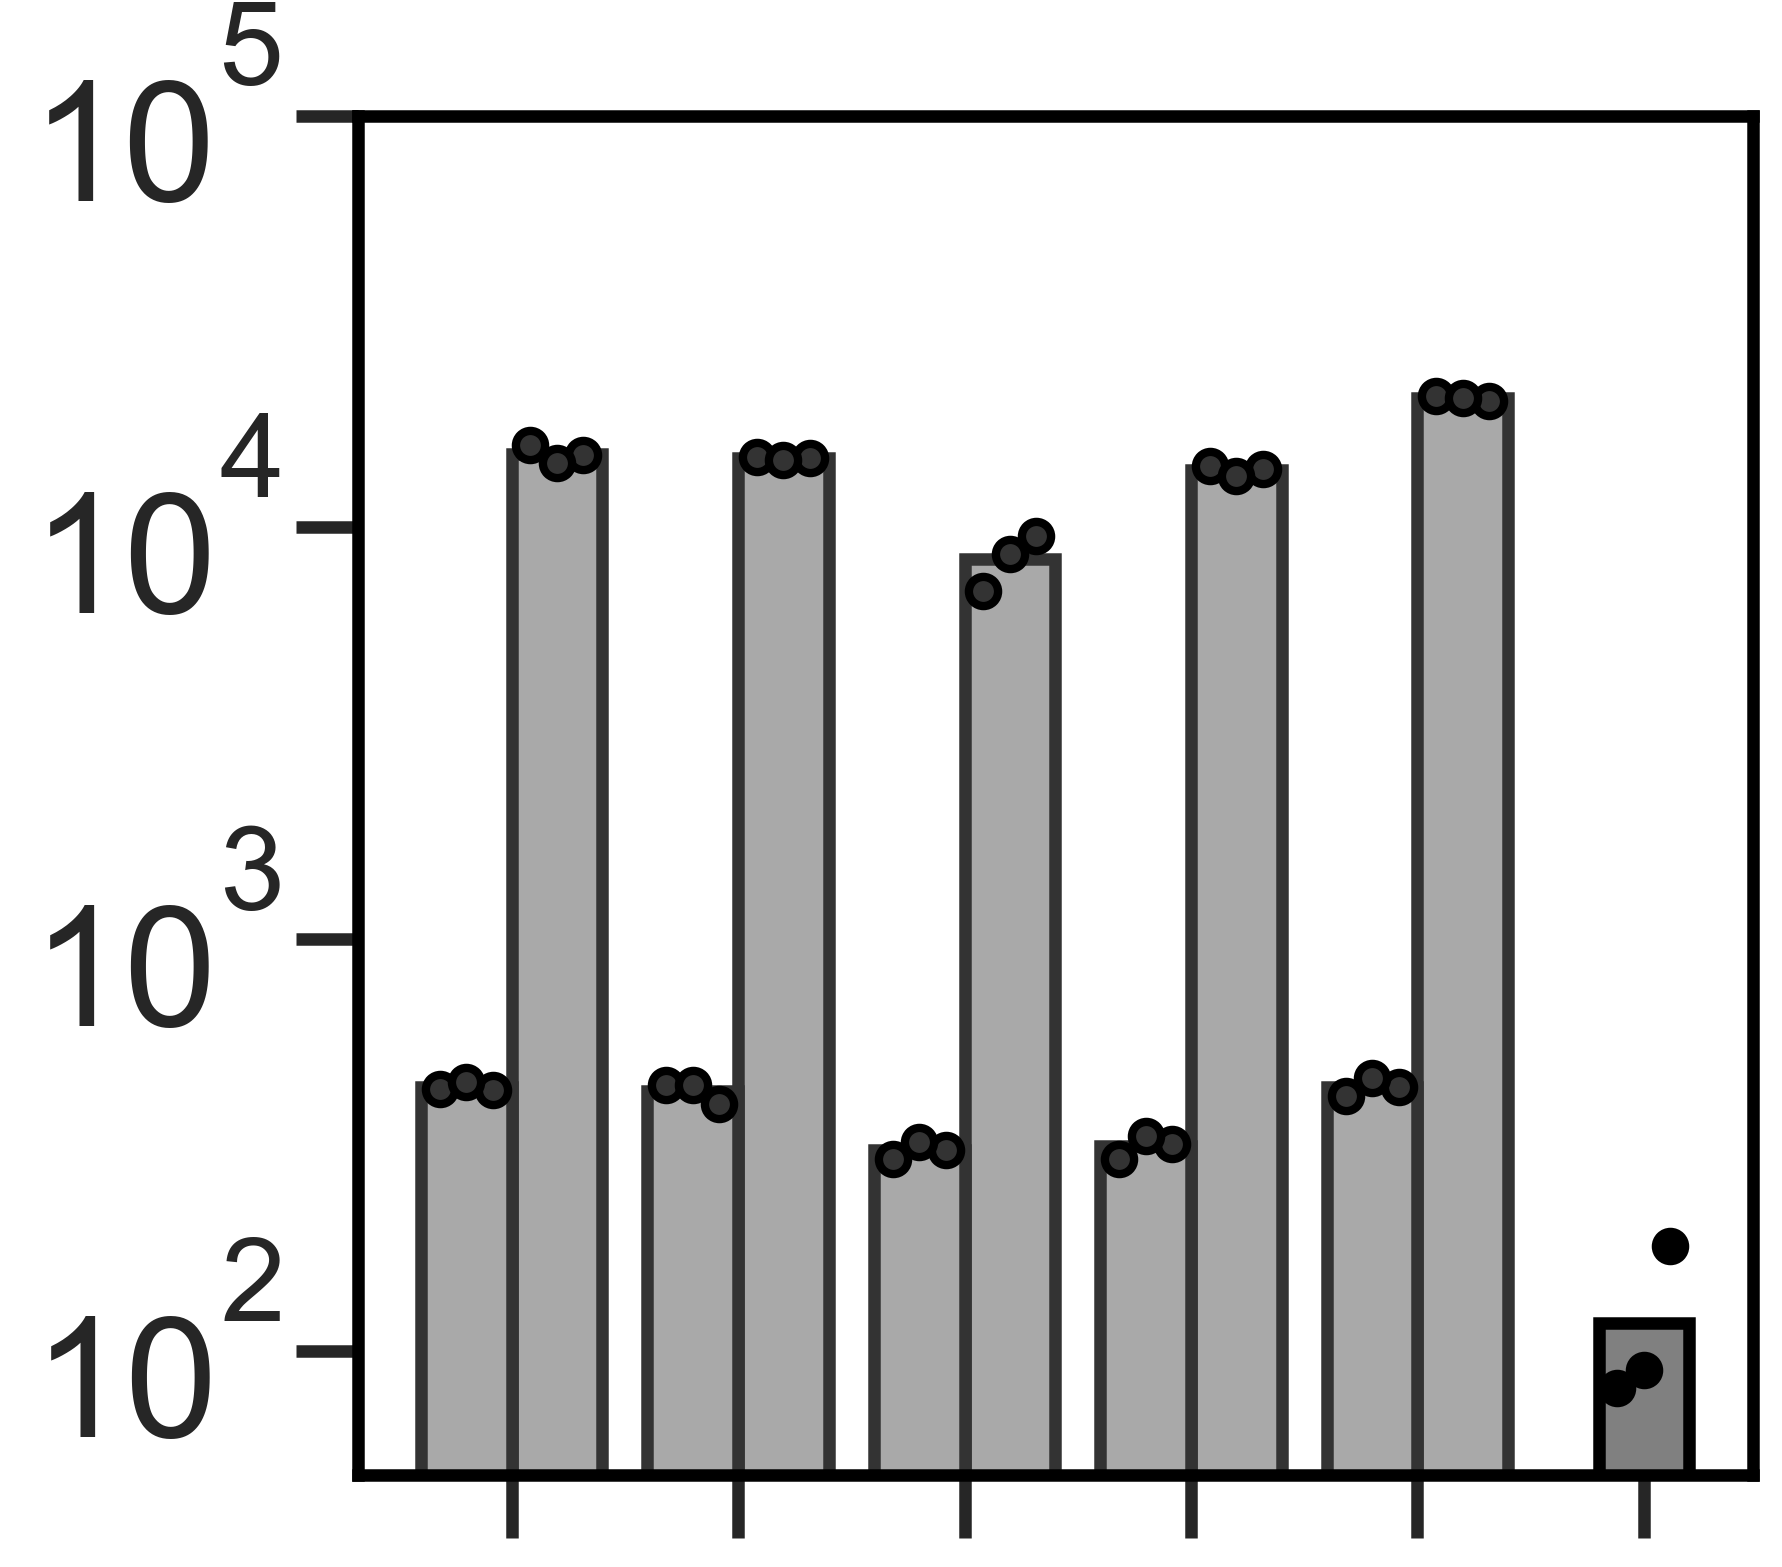

In [16]:
#to generate figure 3b

def plot_med(ax, position, df, name, color, edgecolor):
    ms=7
    mew=2
    mfc=edgecolor#'black'
    mc='black'
    offset=.22
    w=.75
    ew=3   
    
    ax.bar(position, df.loc[df['name']==name,'med'], width=w, color=color, edgecolor=edgecolor, linewidth=ew)
    #plt.errorbar(position,df[df['name']==name]['average'], df[df['name']==name]['std'], fmt='none', ecolor='black',linewidth=2, capsize=capsize)
    #ax.plot(position, df[df['name']==name]['average'], 'o', markersize=20, color=color)
    ax.plot(position-offset, df[df['name']==name]['med1'], 'o', markersize=ms,color=mc, mew=mew, mfc=mfc)
    ax.plot(position+offset, df[df['name']==name]['med2'], 'o', markersize=ms, color=mc, mew=mew, mfc=mfc)
    ax.plot(position, df[df['name']==name]['med3'], 'o', markersize=ms, color=mc, mew=mew, mfc=mfc)

    
w=.75
x=2.5

fig, ax=plt.subplots(figsize=(6,6), dpi=300)
on=['A_on', 'C_on', 'D_on', 'E_on', 'F_on']
off=[ '400_4', '402_4', '403_4', '404_4','405_4']
positions=[1*x*w, 2*x*w, 3*x*w, 4*x*w, 5*x*w]
for name, position, color, edgecolor in zip(on, positions, pastels, darks):
    plot_med(ax, position+w/2, meds, name, 'darkgrey', '#333333')
for name, position in zip(off, positions):
    plot_med(ax, position-w/2, meds, name, 'darkgrey', '#333333')
plot_med(ax, 6*x*w, meds, '1A976', 'grey', 'black')

ax.grid(False)
ax.set_yscale('log')
# ax.set_yticklabels([])

# plt.xlabel('Sequence', fontsize=40)
# plt.ylabel('GFP (median, a.u.)', fontsize=40)
#ax.set_yticks([0, 50000, 100000, 150000])
ax.set_ylim(50, 100000)
ax.set_yticks([1e2, 1e3, 1e4, 1e5])
ax.set_xticks([1*x*w, 2*x*w, 3*x*w, 4*x*w, 5*x*w, 6*x*w])
ax.set_xticklabels([])
#ax.set_ylabel('counts')
#ax.set_xlabel('FITC-A (a.u.)')

ax.tick_params(which='major', direction='out', length=15, width=3)
ax.tick_params(which='minor', direction='out', length=0, width=2)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('black')
ax.tick_params(axis='both', which='major', labelsize=40)

plt.show()
plt.tight_layout()
# fig.savefig('fig3b.pdf', bbox_inches='tight')
plt.close()

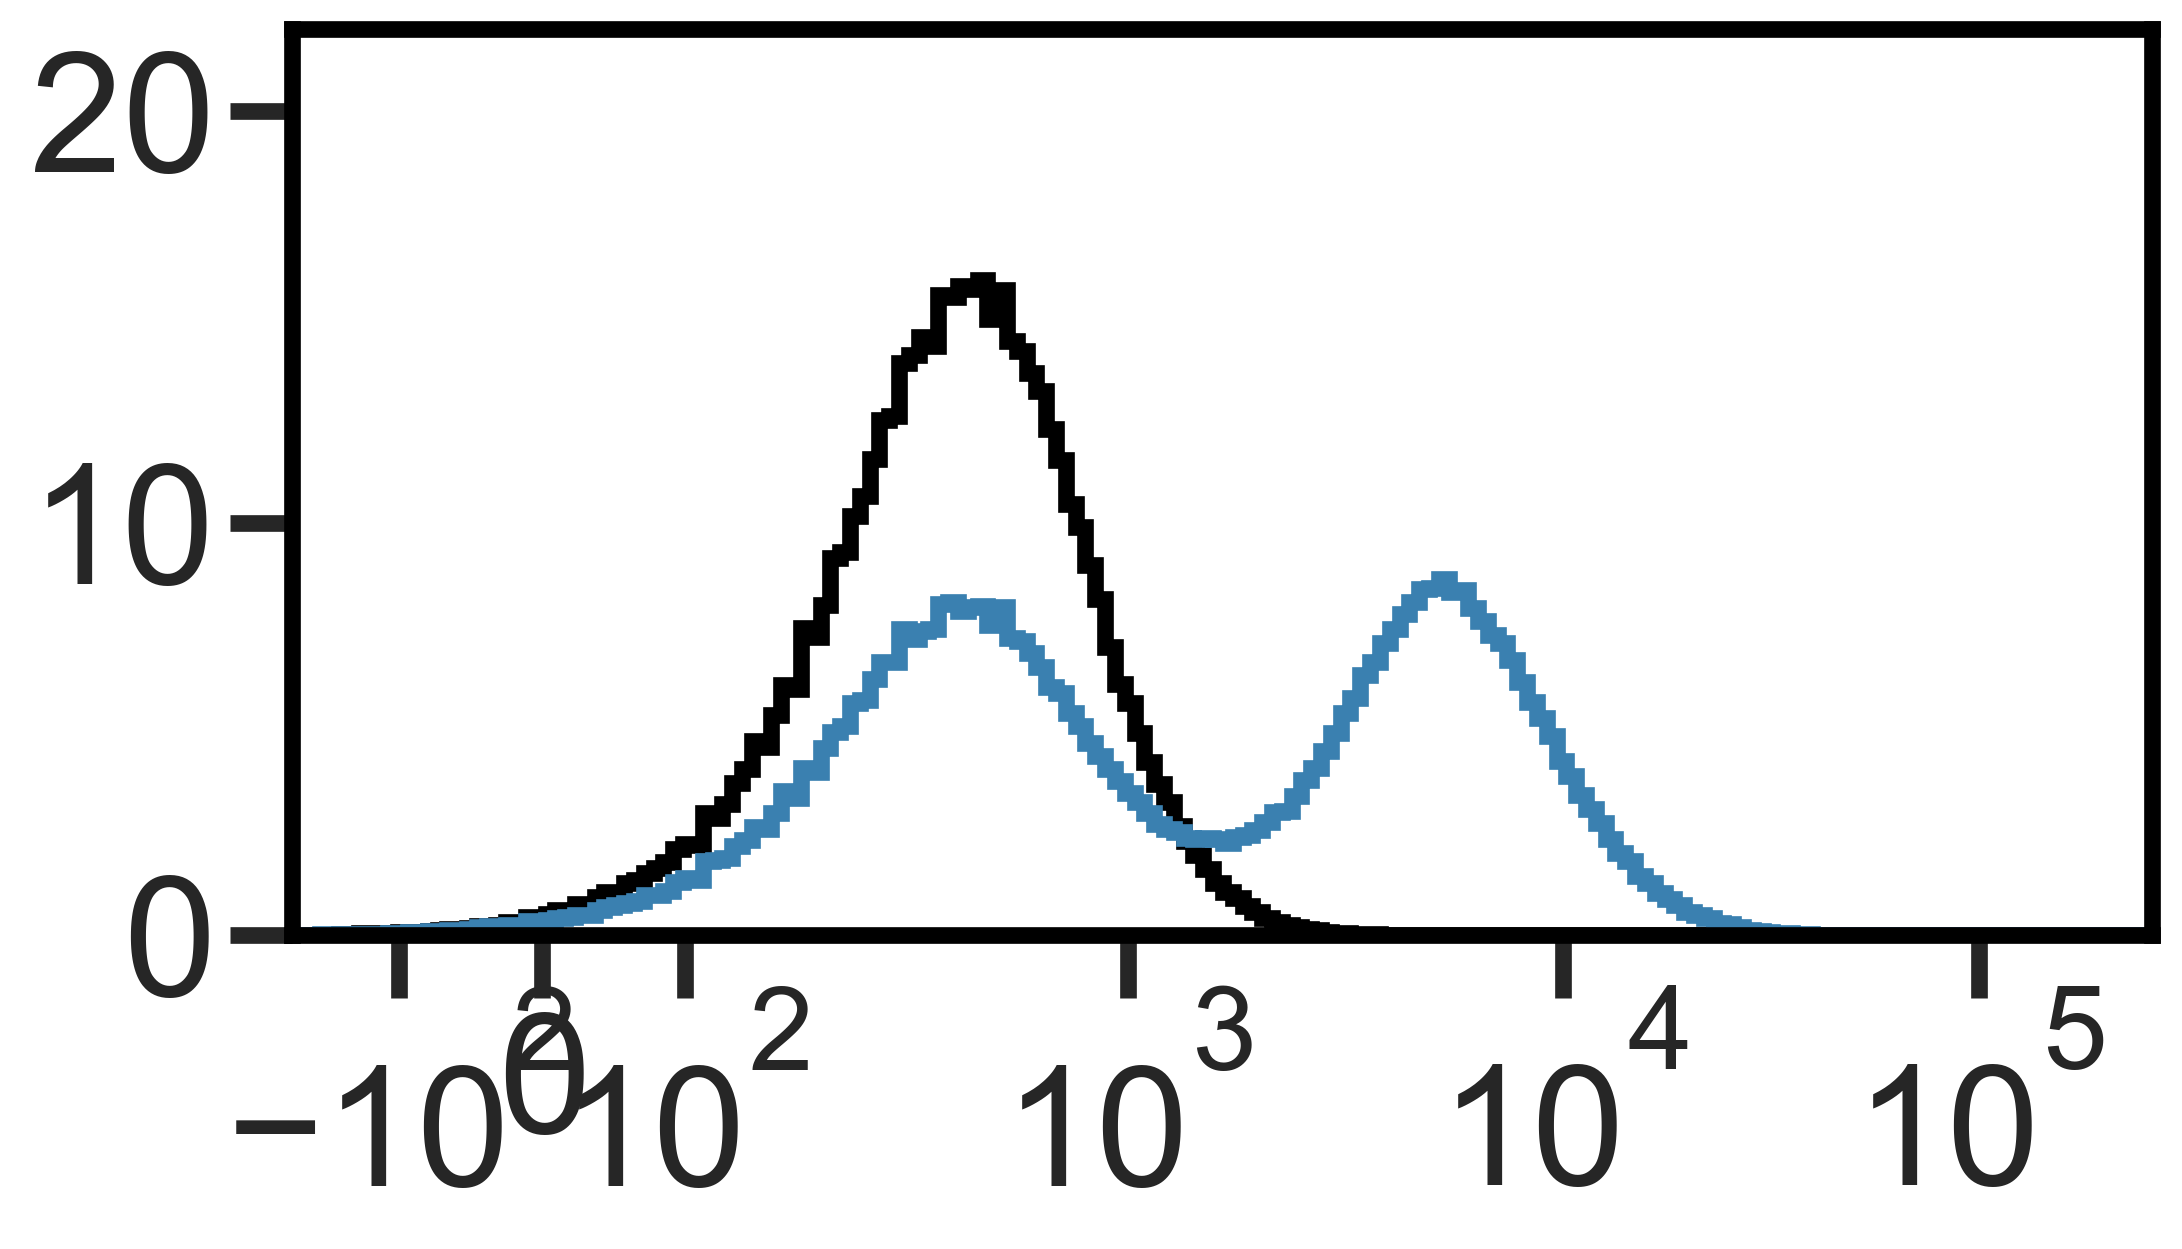

In [20]:
# to generate figure 3c (edit axes labels by hand)

fig, ax1=plt.subplots(figsize=(8,4), dpi=300)
fs=40

ax1.hist(r1.loc[r1['name']=='400_4', 'FITC-A'], 
         bins=bins_logicle, histtype='step', color='black', lw=4)
ax1.hist(r1.loc[r1['name']=='400_1', 'FITC-A'], 
         bins=bins_logicle, histtype='step', color=darks[0], lw=4)

ax1.set_xscale('logicle', **logicle.get_mpl_params(ax1.get_xaxis()))
ax1.grid(False)

ax1.set_yticks([0, 10000, 20000])
ax1.set_yticklabels(['0', '10', '20'])
ax1.set_ylim(0, 22000)

ax1.tick_params(which='major', direction='out', length=15, width=4)
ax1.tick_params(which='minor', direction='out', length=0, width=1)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(4)
    ax1.spines[axis].set_color('black')
ax1.tick_params(axis='both', which='major', labelsize=fs)

plt.show()
plt.tight_layout()
# fig.savefig('fig3c.pdf', bbox_inches='tight')
plt.close()

params 1:
[6.09493797e+00 6.25576007e-01 1.30772830e+04]
params 2:
[8.54661862e+00 5.75615918e-01 1.12839528e+04]


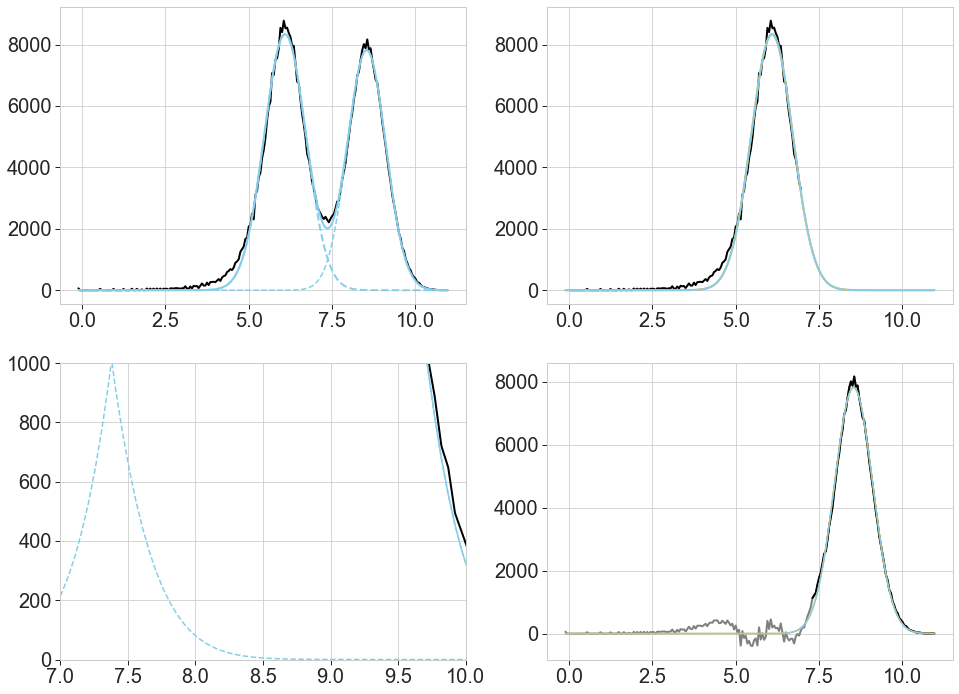

frac neg events clipped: 0.0054401066341197065
A1: 13077.282975900644
mu1: 6.0949379691652865
s1: 0.6255760069869329
A2: 11283.952821663961
mu2: 8.546618620008635
s2: 0.5756159181847548


In [23]:
# code to fit Gaussians (example for one sample)
# heavily based off of 
# https://stackoverflow.com/questions/35990467/fit-two-gaussians-to-a-histogram-from-one-set-of-data-python


def one_gauss_density(x, mu, s, A):
    return A*(1/(np.sqrt(2*np.pi)*s))*np.exp(-(x-mu)**2/(2*s**2))

#define sample to fit here
sample='400_1'
rep='1'
data=np.array(r1.loc[r1['name']==sample, 'FITC-A']) # change dataframe for different reps
inset=True

title=sample+'_r'+rep
binwidth=.05        

fig, [[ax1, ax2], [ax3, ax4]]=plt.subplots(2,2, figsize=(16, 12))

# code to log transform data
x=np.log(data[data>0])
hist, bin_edges=np.histogram(x, bins=int((max(x)-min(x))/binwidth))
bins=(bin_edges[1:]+bin_edges[:-1])/2
ax1.plot(bins, hist, '-', color='black', lw=2)

#code to fit first peak
lower1=0
upper1=7
hist1=hist[(bins>=lower1) & (bins<=upper1)]
bins1=bins[(bins>=lower1) & (bins<=upper1)]

params1, cov1=curve_fit(one_gauss_density, bins1, hist1, (6, .3, 10000), bounds=(0, np.inf))
print('params 1:')
print(params1)

ax2.plot(bins1, hist1, '-', color='black', lw=2)
ax2.plot(bins, one_gauss_density(bins, *params1), '-', color='orange', lw=2)

#set params from first fit (adjust so tail end in ax3 is accurate, only for samples that are clearly off)
mu1=params1[0]
s1=params1[1]
A1=params1[2]

ax2.plot(bins, one_gauss_density(bins, mu1, s1, A1), '-', color='skyblue', lw=2)
ax1.plot(bins, one_gauss_density(bins, mu1, s1, A1), '--', color='skyblue', lw=2)

#calculate remainder 
remainder=hist-one_gauss_density(bins, mu1, s1, A1)

#fit second peak
lower2=7.3
hist2=remainder[(bins>=lower2)]
bins2=bins[(bins>=lower2)]

params2, cov2=curve_fit(one_gauss_density, bins2, hist2, (8.1, .1, 100), bounds=(0, np.inf))
print('params 2:')
print(params2)

#set params from second fit
mu2=params2[0]
s2=params2[1]
A2=params2[2]

ax4.plot(bins, remainder, '-', color='grey', lw=2)
ax4.plot(bins2, hist2, '-', color='black', lw=2)
ax4.plot(bins, one_gauss_density(bins, *params2), '-', color='orange', lw=1.5)
ax4.plot(bins, one_gauss_density(bins, mu2, s2, A2), '-', color='skyblue', lw=1.5)

ax1.plot(bins, one_gauss_density(bins, mu2, s2, A2), '--', color='skyblue', lw=1.5)
fit=one_gauss_density(bins, mu1, s1, A1)+one_gauss_density(bins, mu2, s2, A2)
ax1.plot(bins, fit, '-', color='skyblue', lw=2)

ax3.plot(bins, hist, '-', color='black', lw=2)
ax3.plot(bins, one_gauss_density(bins, mu1, s1, A1), '--', color='skyblue', lw=1.5)
ax3.plot(bins, one_gauss_density(bins, mu2, s2, A2), '--', color='skyblue', lw=1.5)
ax3.plot(bins, fit, '-', color='skyblue', lw=1.5)


ax3.set_xlim(7, 10)
ax3.set_ylim(0, 1000)

plt.show()
plt.close()

frac_area=A2/(A1+A2)

print('frac neg events clipped: '+ str(len(data[data<=0])/len(data)))
print('A1: ' +str(A1))
print('mu1: '+str(mu1))
print('s1: '+ str(s1))
print('A2: '+ str(A2))
print('mu2: '+str(mu2))
print('s2: '+str(s2))


In [24]:
## code for all fits not shown : import csv containing final fit params for all samples

fracs2=pd.read_csv('flow_fig3_fits_all.csv')
fracs2['fa_mean']=fracs2[['fa1', 'fa2', 'fa3']].mean(axis=1)

fracs2

,Unnamed: 0,sample,mu1_1,s1_1,A1_1,mu2_1,s2_1,A2_1,fneg_1,A1+A2,...,s1_3,A1_3,mu2_3,s2_3,A2_3,fneg_3,Unnamed: 29,Unnamed: 30,fa3,fa_mean
0,0,400_1,6.108457,0.649447,13405.802880,8.552371,0.568149,11169.351880,0.005440,24575.15477,...,0.576531,19274.14211,8.236349,0.440307,3946.675622,0.024232,23220.81773,576.653490,0.165844,0.274873
1,1,400_2,6.108629,0.584828,21445.383000,8.646651,0.496274,2597.621794,0.006008,24043.00479,...,0.564899,22367.80441,8.287626,0.352282,641.422879,0.023478,23009.22729,553.190034,0.027222,0.053227
2,2,400_3,6.101505,0.579384,23578.321450,8.709483,0.439563,432.675591,0.006640,24010.99704,...,0.563366,23095.08270,8.405054,0.295972,59.874265,0.021809,23154.95697,516.255299,0.002529,0.007617
3,3,400_4,6.099326,0.577469,23935.342480,8.911383,0.077657,0.276750,0.006444,23935.61923,...,0.559986,23137.26174,8.706697,0.019534,2.906118,0.021446,23140.16786,507.128878,0.000123,0.000066
4,4,400G_1,6.071406,0.577673,14596.755670,8.529488,0.517343,6731.732378,0.006596,21328.48804,...,0.595561,15805.61364,8.297253,0.485754,7752.264828,0.020097,23557.87847,483.163629,0.322460,0.300401
5,5,400G_2,6.103736,0.575000,22722.417240,8.816248,0.512671,1320.037217,0.006057,24042.45446,...,0.555575,22072.22809,8.302148,0.408159,1039.509933,0.021562,23111.73802,509.323243,0.044008,0.042490
6,6,400G_3,6.086071,0.587663,23757.236800,8.851097,0.410323,220.268136,0.006643,23977.50493,...,0.563221,23111.06763,8.456488,0.292872,59.994243,0.021809,23171.06187,516.598636,0.002533,0.004601
7,7,400G_4,6.089205,0.592052,23990.953480,9.532494,0.269783,0.440444,0.006839,23991.39393,...,0.558661,23181.18280,8.622083,0.045273,0.179758,0.020911,23181.36256,495.106566,0.000008,0.000031
8,8,570_1,6.106536,0.595321,23659.911460,8.184103,0.534740,333.988375,0.007292,23993.89984,...,0.563152,23037.20474,8.261448,0.236700,27.922996,0.022073,23065.12774,520.600381,0.001184,0.005457
9,9,570_4,6.086248,0.599585,24079.328610,16.479681,0.129727,5.802704,0.006704,24085.13131,...,0.564769,23272.30395,11.055489,0.157041,8.010935,0.018338,23280.31488,434.890048,0.000338,0.000220


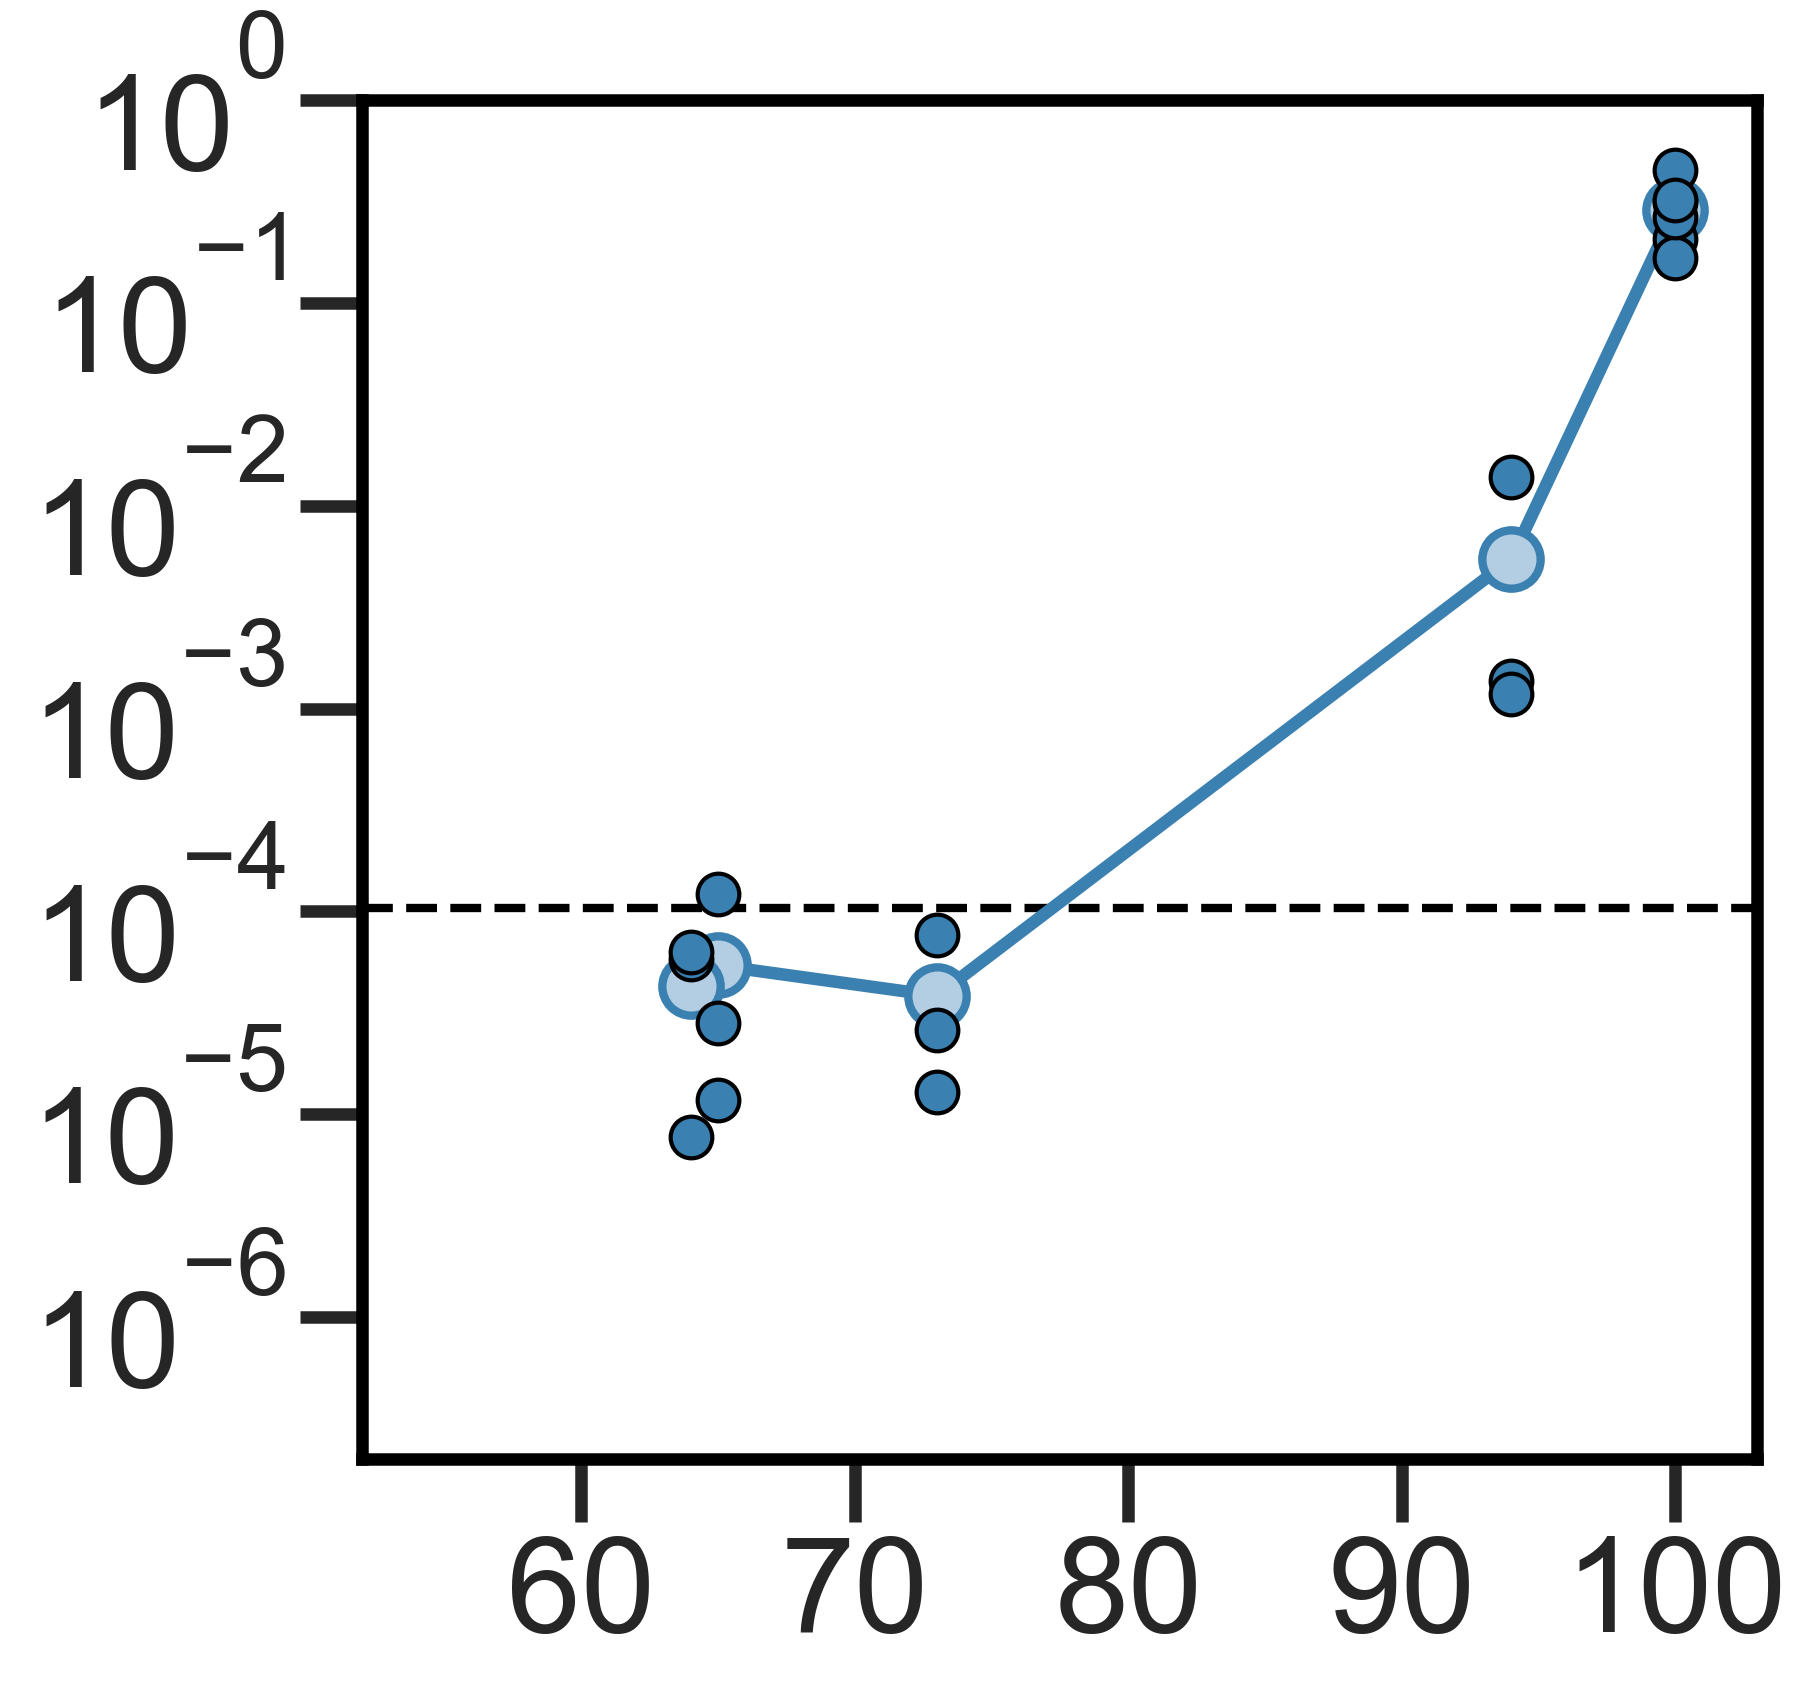

In [27]:
#generate plots for fig 3g

x=[]
y=[]
x_means=[]
y_means=[]
A_x_neg=[]
A_y_neg=[]

for y_val in ['400', '400G']:
    x.append(100)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa1'].values))
    x.append(100)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa2'].values))
    x.append(100)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa3'].values))
    
    A_x_neg.append(100)
    A_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa1'].values))
    A_x_neg.append(100)
    A_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa2'].values))
    A_x_neg.append(100)
    A_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa3'].values))

x_means.append(100)
y_means.append(.5*(float(fracs2.loc[fracs2['sample']=='400_1', 'fa_mean'].values)+float(fracs2.loc[fracs2['sample']=='400G_1', 'fa_mean'].values)))


for x_val, y_val in zip([94, 73, 65, 64], ['570', '571', '573', '572']):
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa1'].values))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa2'].values))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa3'].values))
    x_means.append(x_val)
    y_means.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa_mean']))
    
    A_x_neg.append(x_val)
    A_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa1'].values))
    A_x_neg.append(x_val)
    A_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa2'].values))
    A_x_neg.append(x_val)
    A_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa3'].values))

fig, ax=plt.subplots(figsize=(6,6), dpi=300)


# ax.plot(x_neg_means, y_neg_means, '-o', color='#333333', mfc='grey', ms=10, lw=3, mew=2)
# ax.plot(52*np.ones(len(A_y_neg)), A_y_neg, 'o', color='grey', ms=10, mec='black')
ax.plot([52, 103], [np.mean(A_y_neg), np.mean(A_y_neg)], '--', color='black', lw=2)

ax.plot(x_means, y_means, '-o', color=darks[0], mfc=pastels[0], ms=14, lw=3, mew=2)
ax.plot(x, y, 'o', color=darks[0], ms=10, mec='black')
        
        

ax.grid(False)
ax.set_yscale('log')
ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_ylim(2e-7, 1e0)
ax.set_xticks([60, 70, 80, 90, 100])
ax.set_xlim(52, 103)
ax.tick_params(which='major', direction='out', length=15, width=3)
ax.tick_params(which='minor', direction='out', length=0, width=1)
ax.tick_params(axis='both', which='major', labelsize=32)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('black')


plt.show()
plt.tight_layout()
# fig.savefig('fig3g.pdf', bbox_inches='tight')
plt.close()

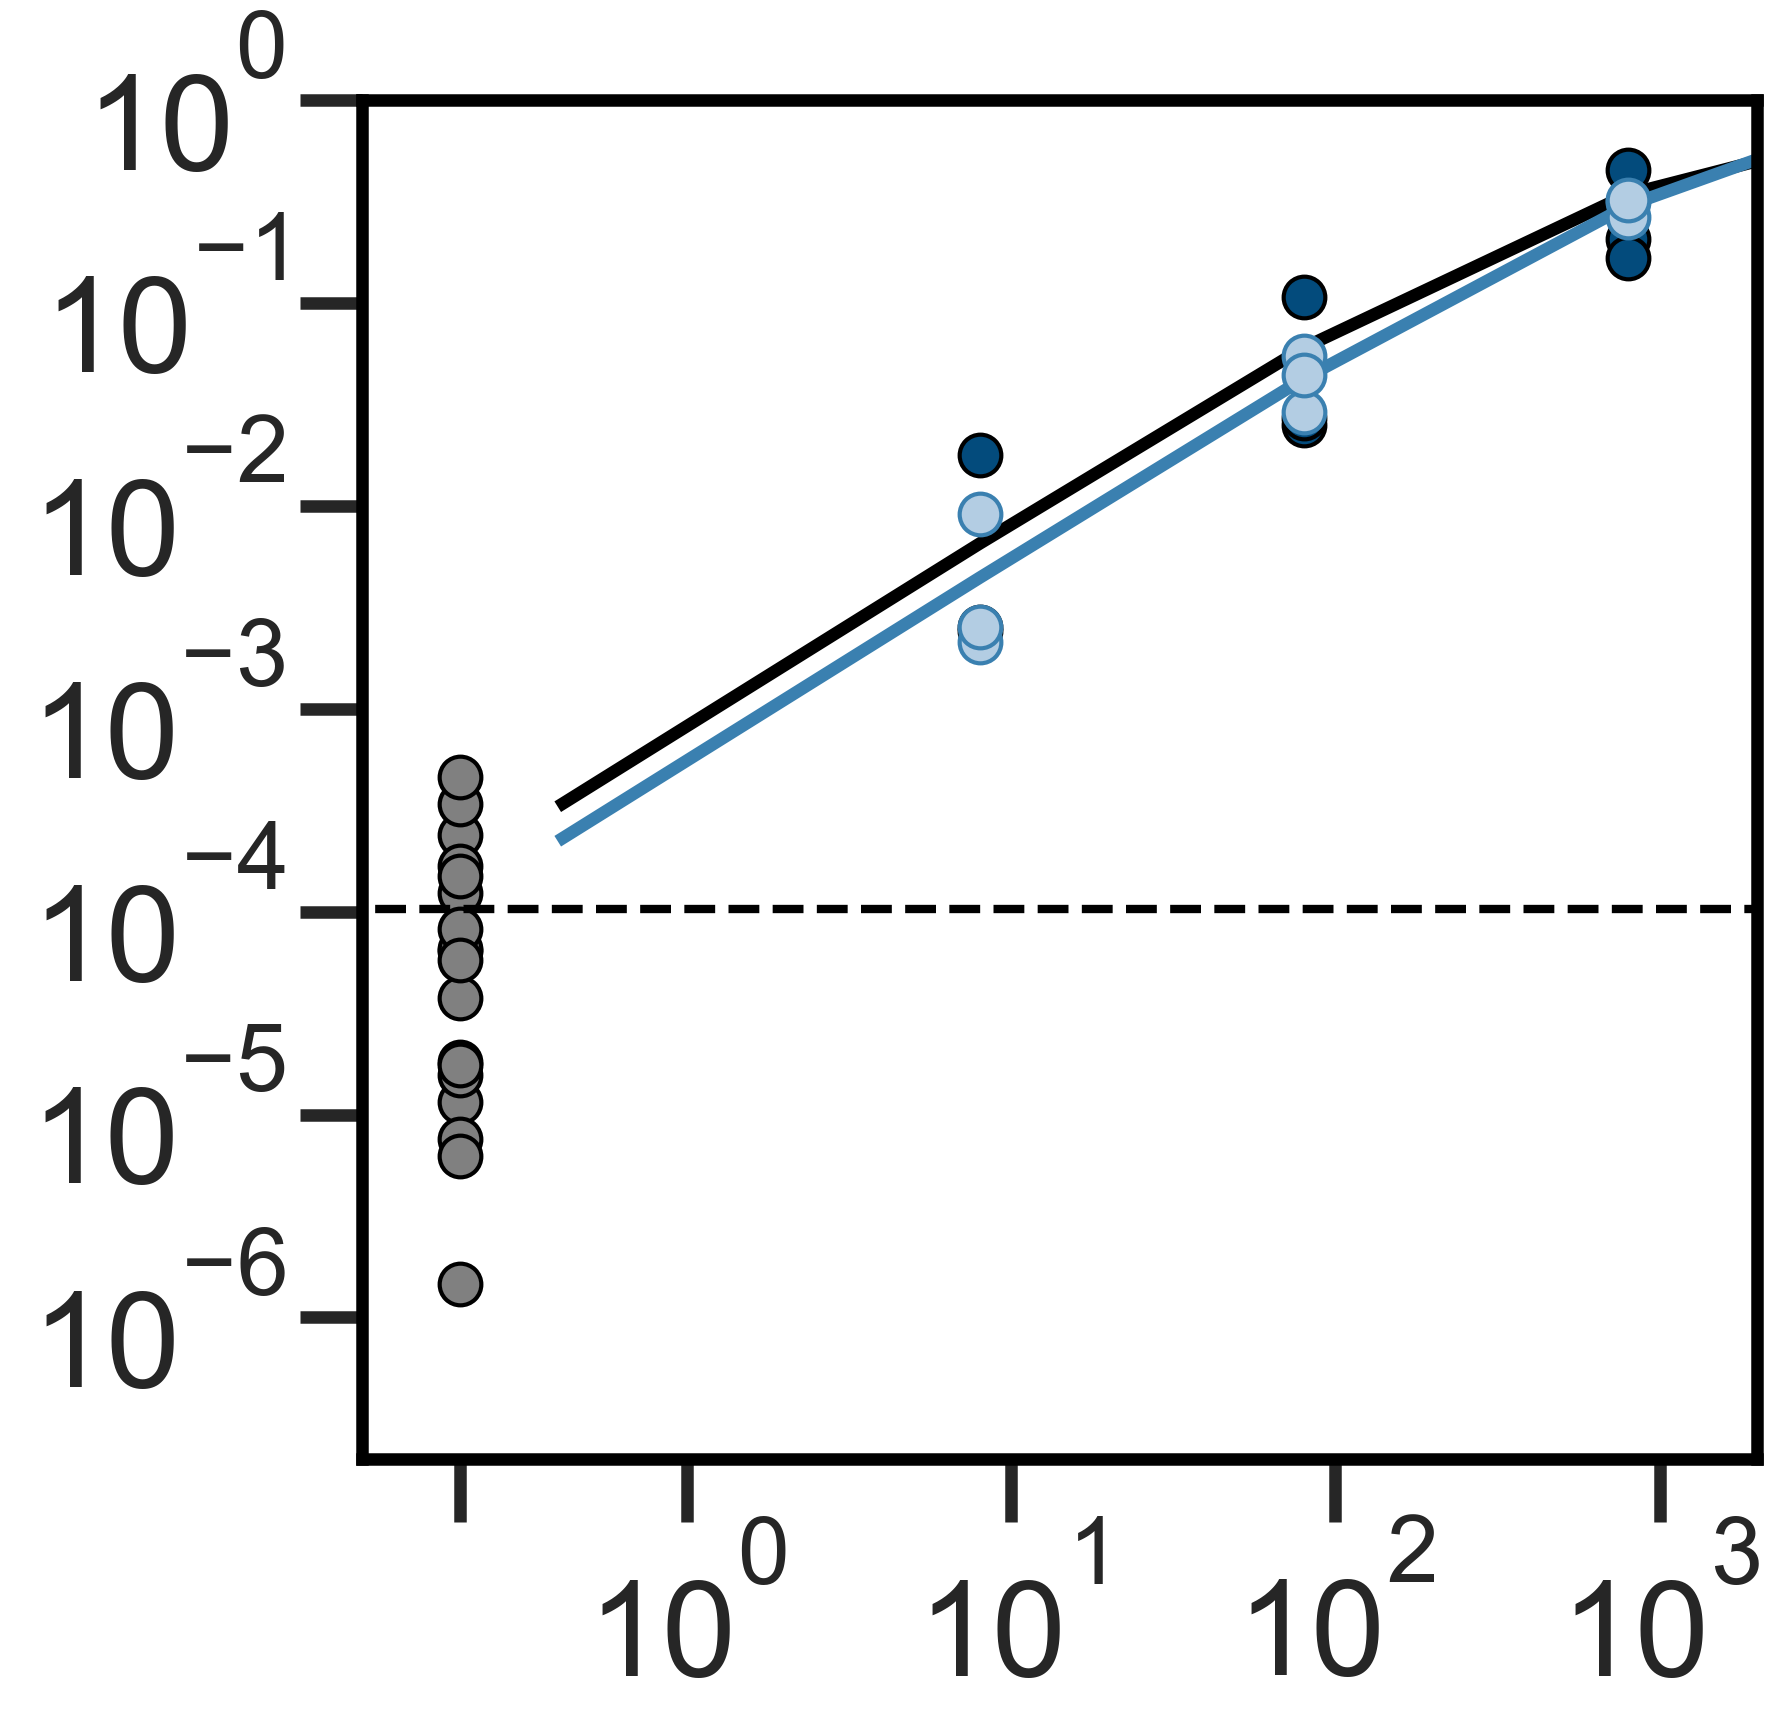

In [29]:
#generate fits for figure 3e (including fitting to transformation model)

def fit_fxn(x, B_o, K):
    # B_o is initial # competent cells
    # K is ratio of k1 (competent cells-> non-competent cells) and k2 (competent cell -> transformed cells)
    # x is [DNA]
    return B_o*(x/(K+x))

def l2_cost_fxn(params, x, y):
    C=params[0]
    K=params[1]
    ypred=fit_fxn(x, C, K)
    err=sum(((y-ypred))**2/y)
    return(err)
x=[]
y=[]
x_means=[]
y_means=[]

x2=[]
y2=[]
x2_means=[]
y2_means=[]


for x_val, y_val in zip([800, 80, 8], ['_1', '_2', '_3']):
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='400'+y_val, 'fa1']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='400'+y_val, 'fa2']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='400'+y_val, 'fa3']))
    x_means.append(x_val)
    y_means.append(float(fracs2.loc[fracs2['sample']=='400'+y_val, 'fa_mean']))
    
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='400G'+y_val, 'fa1']))
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='400G'+y_val, 'fa2']))
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='400G'+y_val, 'fa3']))
    x2_means.append(x_val)
    y2_means.append(float(fracs2.loc[fracs2['sample']=='400G'+y_val, 'fa_mean']))

xlog=np.log(x)
ylog=np.log(y)
x2log=np.log(x2)
y2log=np.log(y2)

print(xlog)
print(ylog)
print(x2log)
print(y2log)

p0=[.7, 1000]

#minimize log transformed l2 cost fxn
output1=minimize(test_l2_cost_fxn, p0, args=(xlog, ylog), method='Nelder-mead')
params1=output1.x
print(output1)

output2=minimize(test_l2_cost_fxn, p0, args=(x2log, y2log), method='Nelder-mead')
params2=output2.x
print(output2)


#plot data
fig, ax=plt.subplots(figsize=(6,6), dpi=300)


ax.plot(.2*np.ones(len(A_y_neg)), A_y_neg, 'o', color='grey', ms=10, mec='black')
ax.plot([.08,2000], [np.mean(A_y_neg), np.mean(A_y_neg)], '--', color='black', lw=2)
ax.plot([.4, 8, 80, 800, 2000], fit_fxn(np.array([.4, 8, 80, 800, 2000]), *params1), '-', color='black', lw=3, solid_capstyle='butt')
ax.plot([.4, 8, 80, 800,2000], fit_fxn(np.array([.4, 8, 80, 800, 2000]), *params2), '-', color=darks[0], lw=3, solid_capstyle='butt')
ax.plot(x, y, 'o', color='#034B7C', ms=10, mec='black')
ax.plot(x2, y2, 'o', color=pastels[0], ms=10, mec=darks[0])
        

ax.grid(False)
ax.set_yscale('log')
ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_ylim(2e-7, 1e0)
ax.set_xscale('log')
ax.set_xticks([.2, 1e0, 1e1, 1e2, 1e3])
ax.set_xlim(.1, 2000)
ax.tick_params(which='major', direction='out', length=15, width=3)
ax.tick_params(which='minor', direction='out', length=0, width=1)
ax.tick_params(axis='both', which='major', labelsize=32)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('black')


plt.show()
plt.tight_layout()
# fig.savefig('fig3e.pdf', bbox_inches='tight')
plt.close()

In [37]:
# SEN2

[6.68461173 6.68461173 6.68461173 4.38202663 4.38202663 4.38202663
 2.07944154 2.07944154 2.07944154]
[-0.52893972 -1.56221425 -1.21047726 -1.9696086  -4.00825685 -3.26298736
 -3.51649353 -6.7503798  -5.59152132]
[6.68461173 6.68461173 6.68461173 4.38202663 4.38202663 4.38202663
 2.07944154 2.07944154 2.07944154]
[-1.00701439 -2.33138728 -2.24368338 -2.63614796 -4.79442573 -4.16280019
 -4.30739683 -7.96778648 -5.88009922]
 final_simplex: (array([[  1.0691434 , 957.80016423],
       [  1.06914337, 957.80011716],
       [  1.06914342, 957.80018506]]), array([1.08656157, 1.08656157, 1.08656157]))
           fun: 1.0865615707073422
       message: 'Optimization terminated successfully.'
          nfev: 125
           nit: 65
        status: 0
       success: True
             x: array([  1.0691434 , 957.80016423])
 final_simplex: (array([[7.26878620e-01, 1.48069536e+03],
       [7.26878647e-01, 1.48069544e+03],
       [7.26878632e-01, 1.48069541e+03]]), array([0.83378834, 0.83378834, 0.833

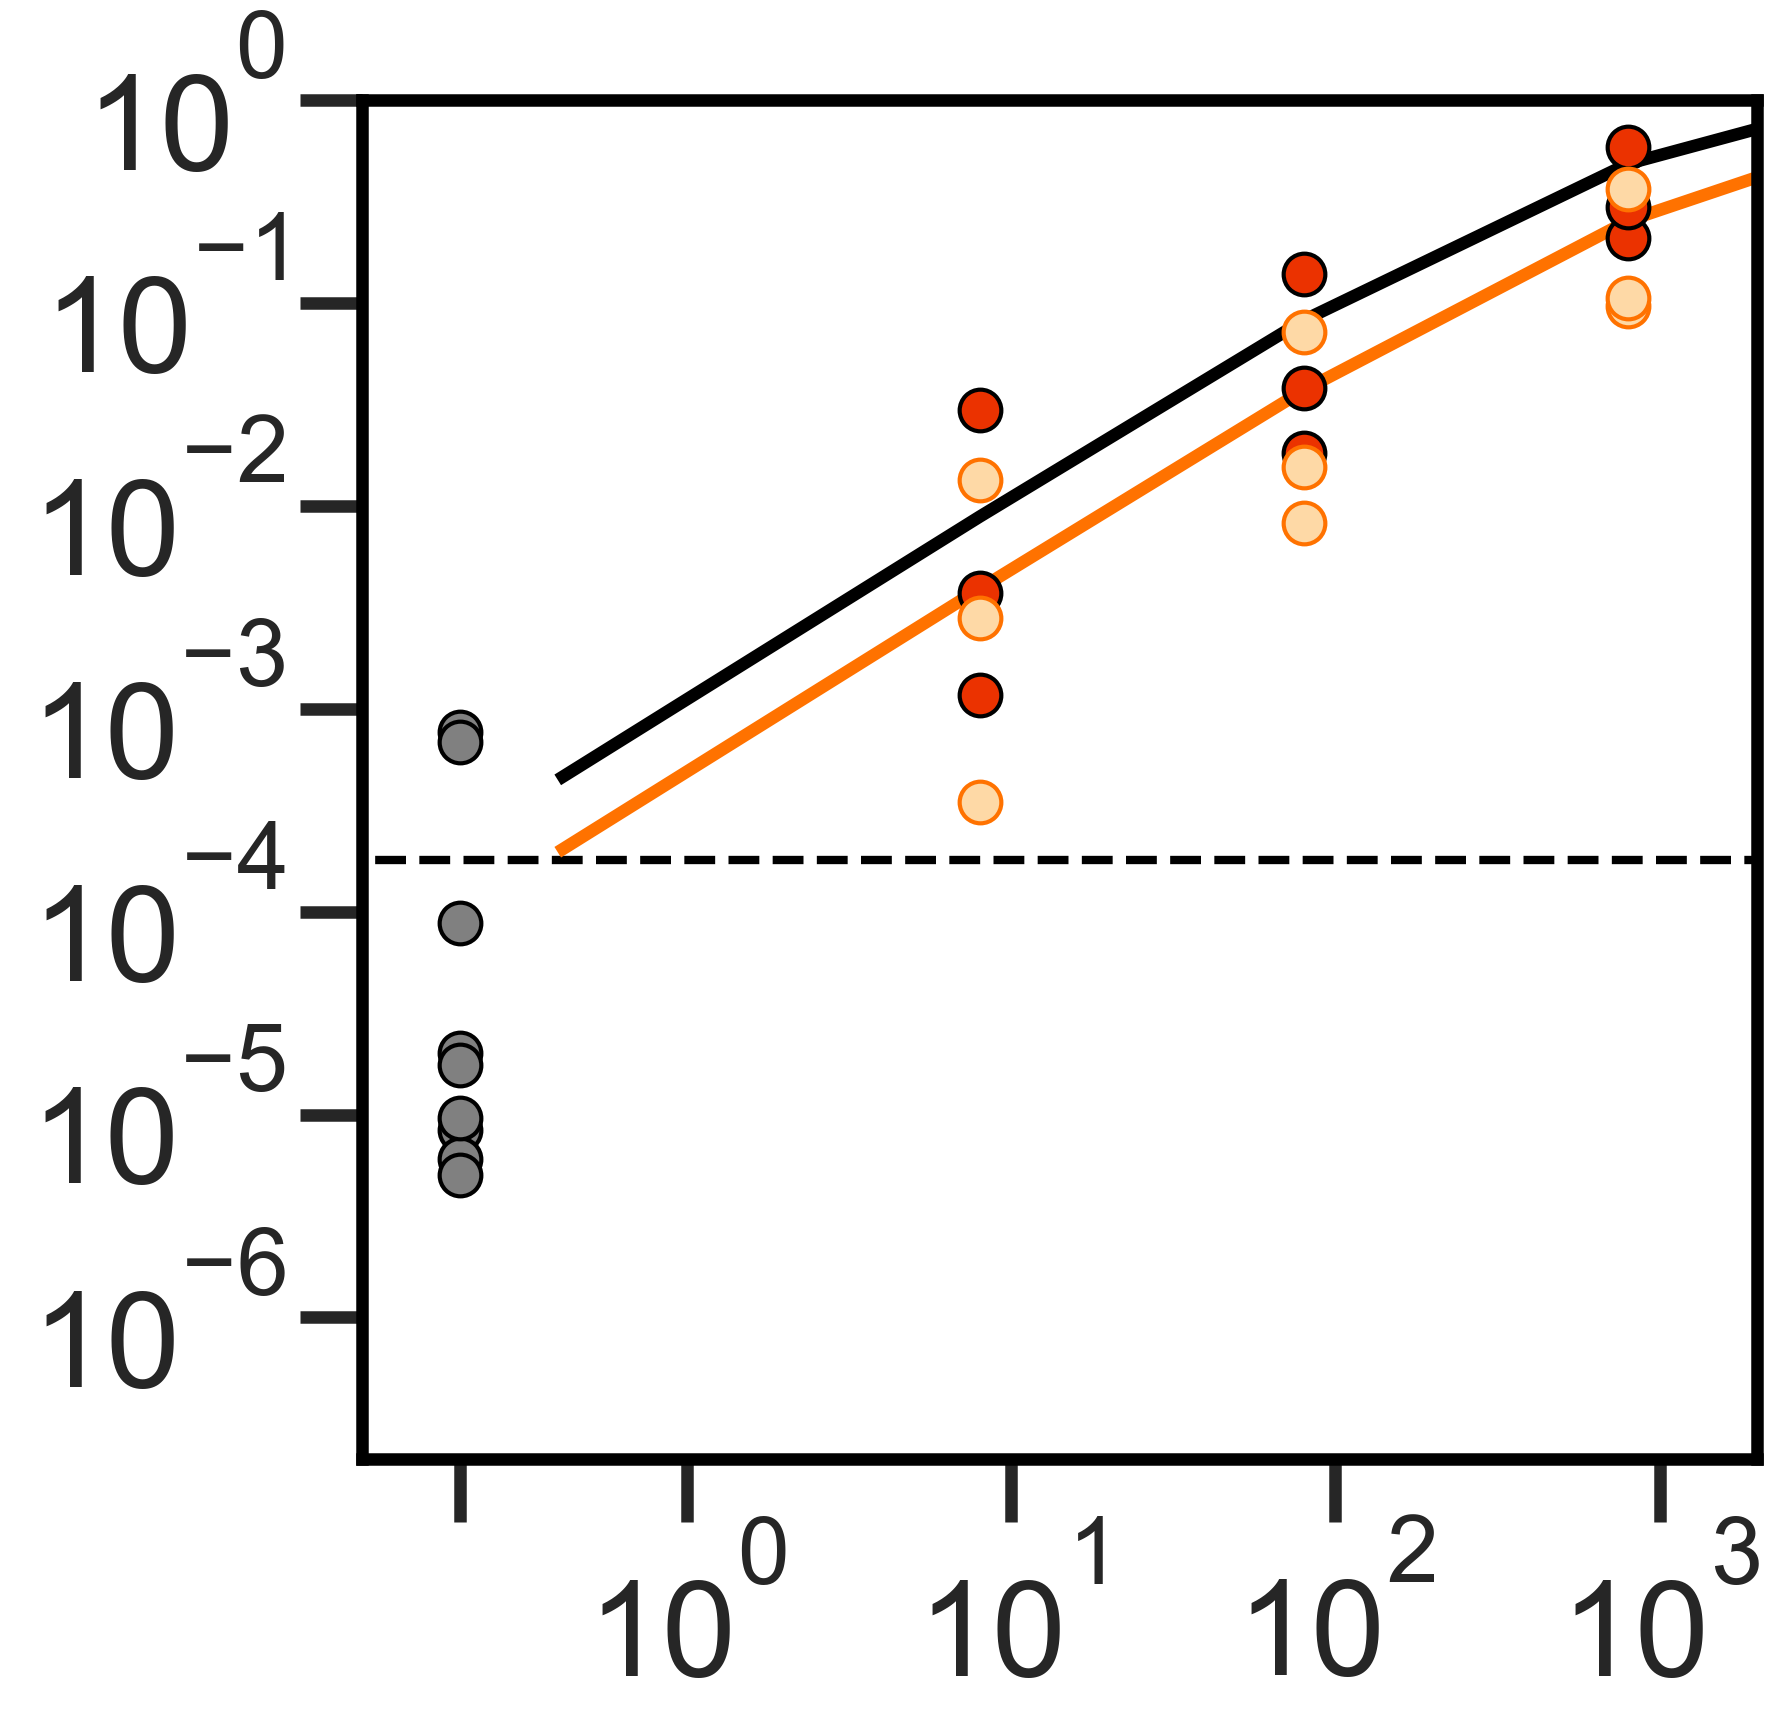

In [36]:
#for SEN2 

x=[]
y=[]
x_means=[]
y_means=[]

x2=[]
y2=[]
x2_means=[]
y2_means=[]



for x_val, y_val in zip([800, 80, 8], ['_1', '_2', '_3']):
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='402'+y_val, 'fa1']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='402'+y_val, 'fa2']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='402'+y_val, 'fa3']))
    x_means.append(x_val)
    y_means.append(float(fracs2.loc[fracs2['sample']=='402'+y_val, 'fa_mean']))
    
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='402C'+y_val, 'fa1']))
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='402C'+y_val, 'fa2']))
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='402C'+y_val, 'fa3']))
    x2_means.append(x_val)
    y2_means.append(float(fracs2.loc[fracs2['sample']=='402C'+y_val, 'fa_mean']))


xlog=np.log(x)
ylog=np.log(y)
x2log=np.log(x2)
y2log=np.log(y2)



p0=[.7, 1000]

#minimize log transformed l2 cost fxn
output1=minimize(test_l2_cost_fxn, p0, args=(xlog, ylog), method='Nelder-mead')
params1=output1.x
print(output1)

output2=minimize(test_l2_cost_fxn, p0, args=(x2log, y2log), method='Nelder-mead')
params2=output2.x
print(output2)



fig, ax=plt.subplots(figsize=(6,6), dpi=300)


# ax.plot(x_neg_means, y_neg_means, '-o', color='#333333', mfc='grey', ms=10, lw=3, mew=2)
ax.plot(.2*np.ones(len(C_y_neg)), C_y_neg, 'o', color='grey', ms=10, mec='black')
ax.plot([.08,2000], [np.mean(C_y_neg), np.mean(C_y_neg)], '--', color='black', lw=2)

ax.plot([.4, 8, 80, 800, 2000], fit_fxn(np.array([.4, 8, 80, 800, 2000]), *params1), '-', color='black', lw=3, solid_capstyle='butt')

ax.plot([.4, 8, 80, 800,2000], fit_fxn(np.array([.4, 8, 80, 800, 2000]), *params2), '-', color=darks[1], lw=3, solid_capstyle='butt')

# ax.plot(x_means, y_means, '-', color='#034B7C', mfc=pastels[0], ms=14, lw=3, mew=2, solid_capstyle='butt')
ax.plot(x, y, 'o', color='#EB3200', ms=10, mec='black')
# ax.plot(x2_means, y2_means, '-', color='#5B97C0', mfc=pastels[0], ms=14, lw=3, mew=2, solid_capstyle='butt')
ax.plot(x2, y2, 'o', color=pastels[1], ms=10, mec=darks[1])
        

ax.grid(False)
ax.set_yscale('log')
ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_ylim(2e-7, 1e0)
ax.set_xscale('log')
ax.set_xticks([.2, 1e0, 1e1, 1e2, 1e3])
ax.set_xlim(.1, 2000)
ax.tick_params(which='major', direction='out', length=15, width=3)
ax.tick_params(which='minor', direction='out', length=0, width=1)
ax.tick_params(axis='both', which='major', labelsize=32)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('black')


plt.show()
plt.tight_layout()
# fig.savefig('SEN2.pdf', bbox_inches='tight')
plt.close()

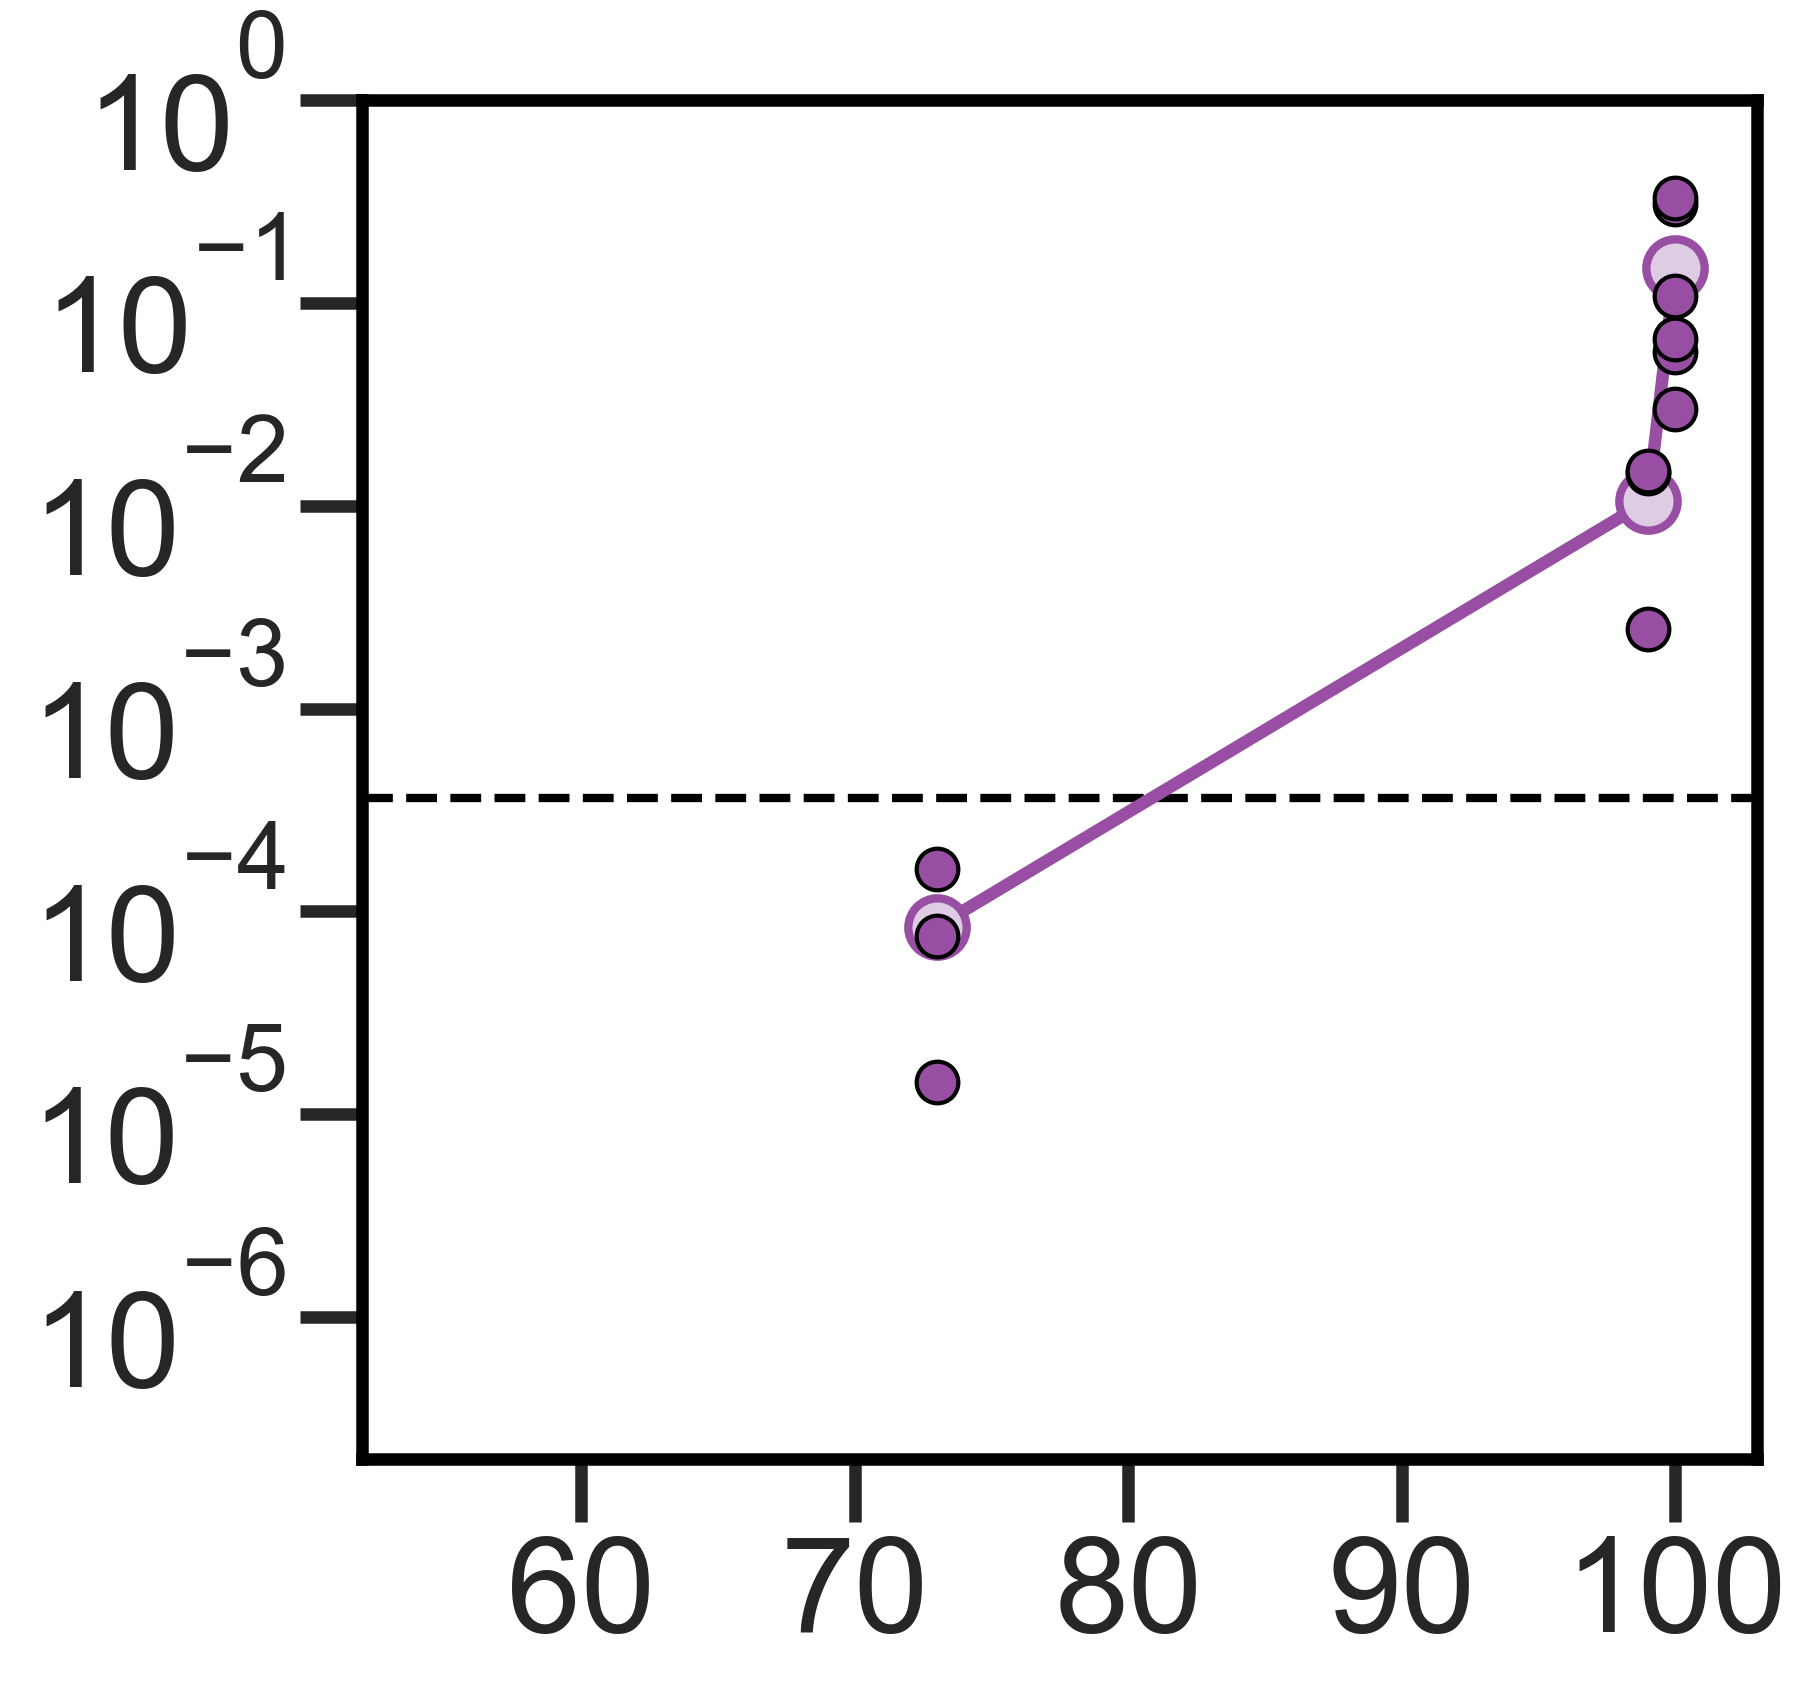

In [31]:
#for SEN3
x=[]
y=[]
x_means=[]
y_means=[]
D_x_neg=[]
D_y_neg=[]

for y_val in ['403', '403G']:
    x.append(100)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa1']))
    x.append(100)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa2']))
    x.append(100)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa3']))
    
    D_x_neg.append(100)
    D_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa1']))
    D_x_neg.append(100)
    D_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa2']))
    D_x_neg.append(100)
    D_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa3']))

x_means.append(100)
y_means.append(.5*(float(fracs2.loc[fracs2['sample']=='403_1', 'fa_mean'])+float(fracs2.loc[fracs2['sample']=='403G_1', 'fa_mean'])))

for x_val, y_val in zip([99,73], ['575', '576']):
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa1']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa2']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa3']))
    x_means.append(x_val)
    y_means.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa_mean']))
    
    D_x_neg.append(x_val)
    D_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa1']))
    D_x_neg.append(x_val)
    D_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa2']))
    D_x_neg.append(x_val)
    D_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa3']))


fig, ax=plt.subplots(figsize=(6,6), dpi=300)


# ax.plot(x_neg_means, y_neg_means, '-o', color='#333333', mfc='grey', ms=10, lw=3, mew=2)
# ax.plot(52*np.ones(len(D_y_neg)), D_y_neg, 'o', color='grey', ms=10, mec='black')
ax.plot([52, 103], [np.mean(D_y_neg), np.mean(D_y_neg)], '--', color='black', lw=2)

ax.plot(x_means, y_means, '-o', color=darks[2], mfc=pastels[2], ms=14, lw=3, mew=2)
ax.plot(x, y, 'o', color=darks[2], ms=10, mec='black')
        
        

ax.grid(False)
ax.set_yscale('log')
ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_ylim(2e-7, 1e0)
ax.set_xticks([60, 70, 80, 90, 100])
ax.set_xlim(52, 103)
ax.tick_params(which='major', direction='out', length=15, width=3)
ax.tick_params(which='minor', direction='out', length=0, width=1)
ax.tick_params(axis='both', which='major', labelsize=32)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('black')


plt.show()
plt.tight_layout()
# fig.savefig(output+'/D_homologs_fit2.pdf', bbox_inches='tight')
plt.close()


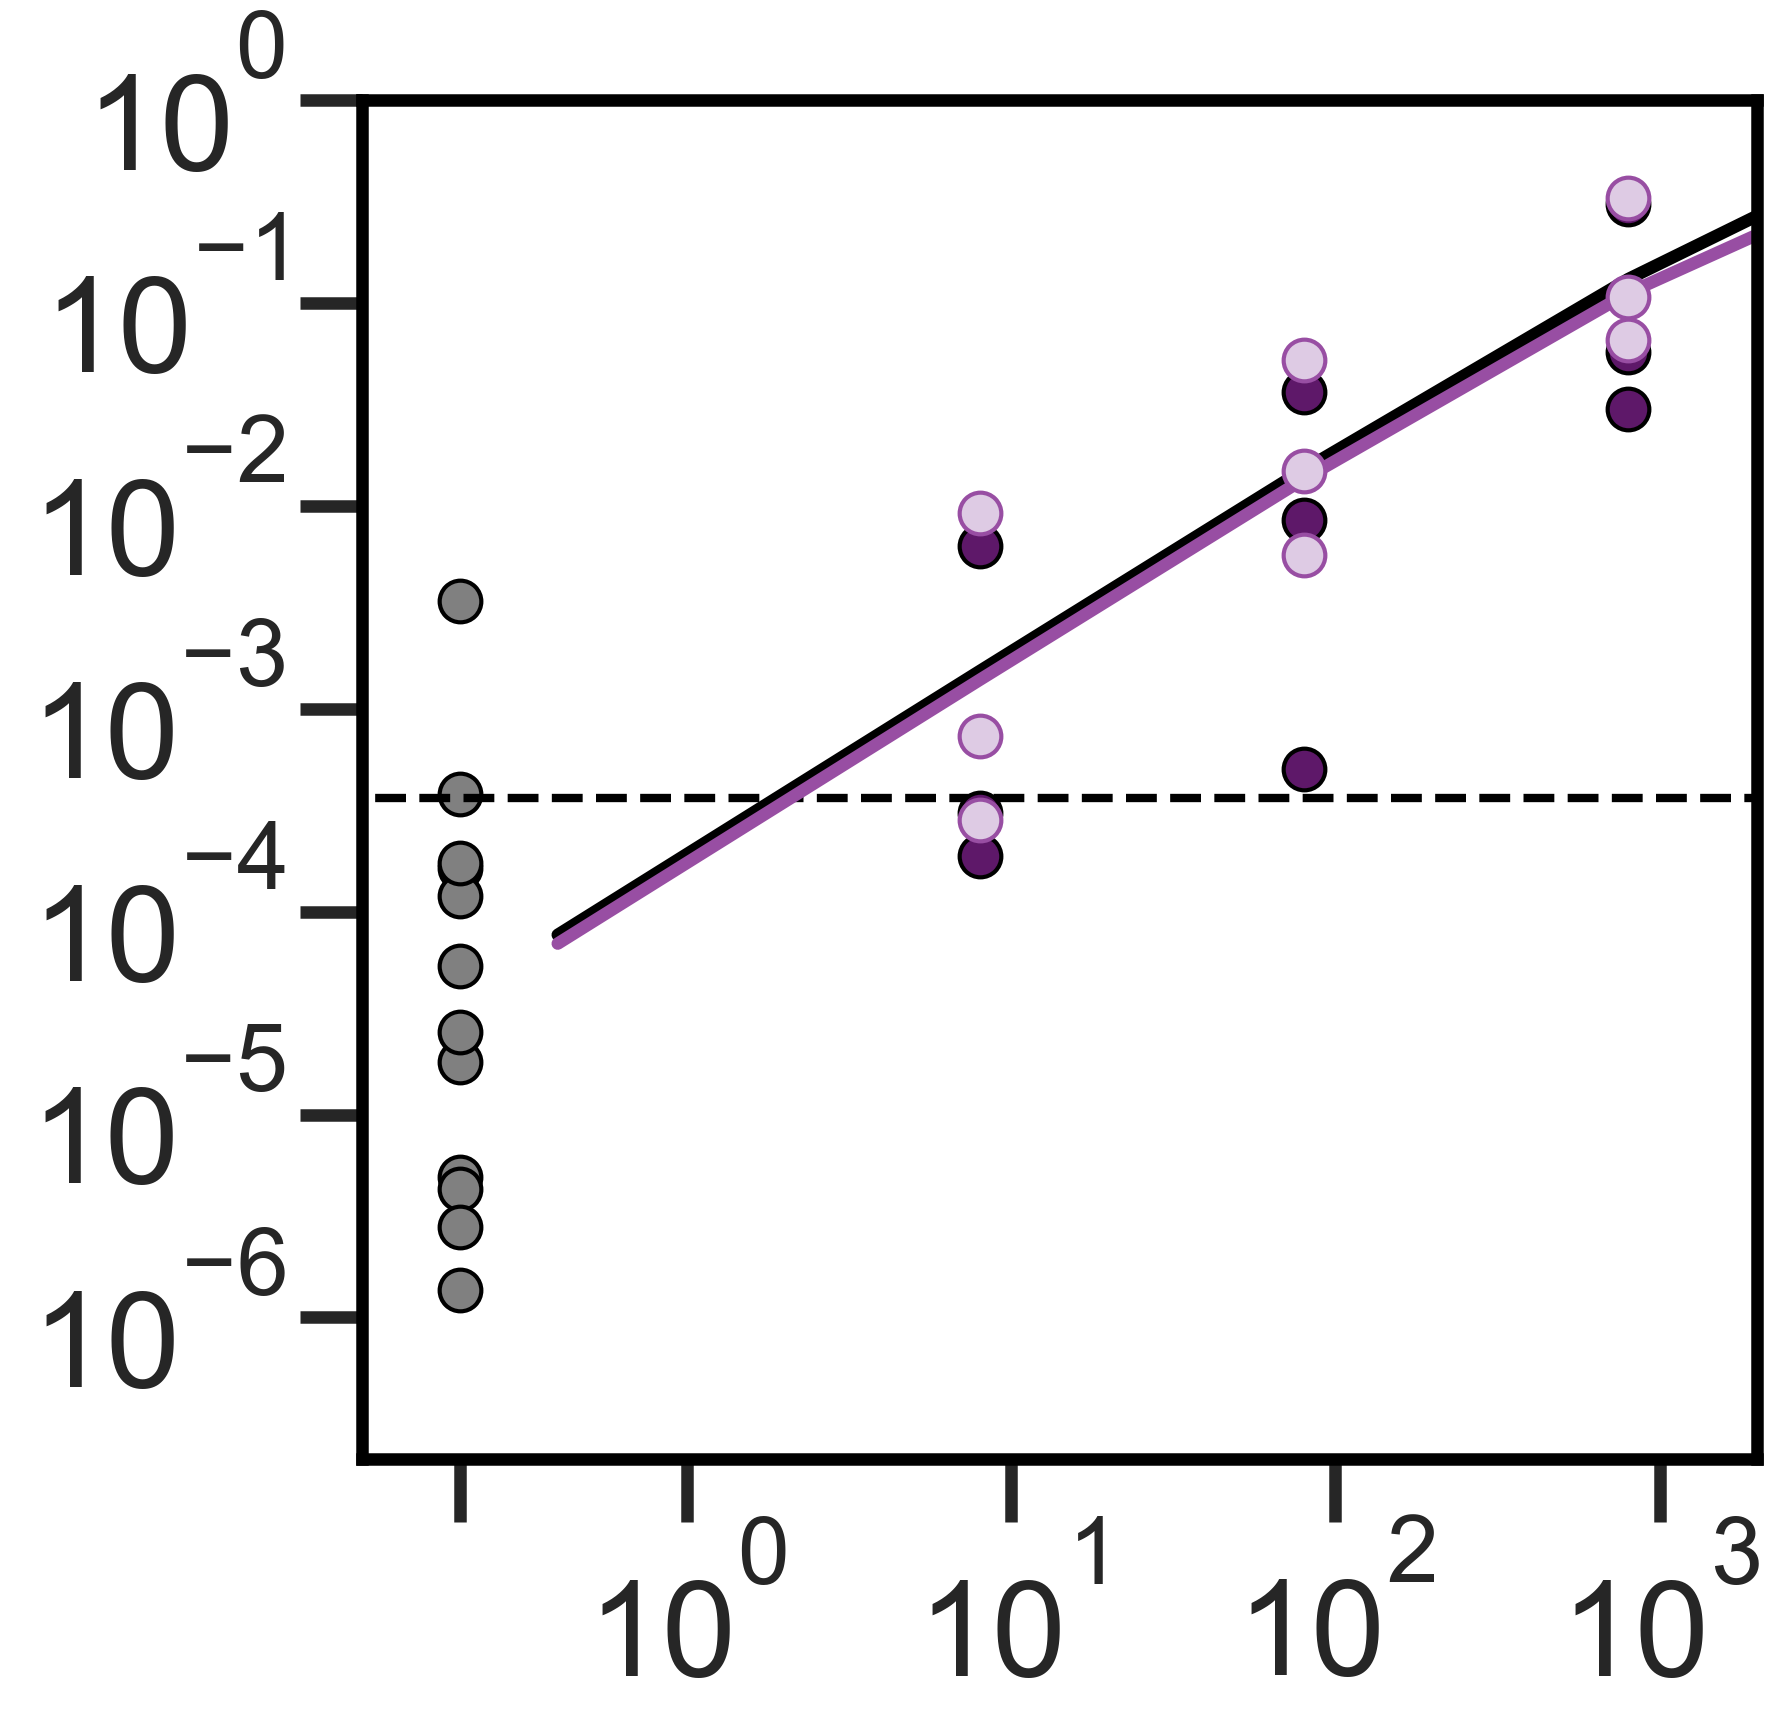

In [38]:
#for SEN3#PLOT NEW FIT, D

x=[]
y=[]
x_means=[]
y_means=[]

x2=[]
y2=[]
x2_means=[]
y2_means=[]


for x_val, y_val in zip([800, 80, 8], ['_1', '_2', '_3']):
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='403'+y_val, 'fa1']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='403'+y_val, 'fa2']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='403'+y_val, 'fa3']))
    x_means.append(x_val)
    y_means.append(float(fracs2.loc[fracs2['sample']=='403'+y_val, 'fa_mean']))
    
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='403G'+y_val, 'fa1']))
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='403G'+y_val, 'fa2']))
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='403G'+y_val, 'fa3']))
    x2_means.append(x_val)
    y2_means.append(float(fracs2.loc[fracs2['sample']=='403G'+y_val, 'fa_mean']))

params1=[0.903880582, 4703.57724]
params2=[.58, 3333]

fig, ax=plt.subplots(figsize=(6,6), dpi=300)


# ax.plot(x_neg_means, y_neg_means, '-o', color='#333333', mfc='grey', ms=10, lw=3, mew=2)
ax.plot(.2*np.ones(len(D_y_neg)), D_y_neg, 'o', color='grey', ms=10, mec='black')
ax.plot([.08,2000], [np.mean(D_y_neg), np.mean(D_y_neg)], '--', color='black', lw=2)

ax.plot([.4, 8, 80, 800, 2000], fit_fxn(np.array([.4, 8, 80, 800, 2000]), *params1), '-', color='black', lw=3)

ax.plot([.4, 8, 80, 800,2000], fit_fxn(np.array([.4, 8, 80, 800, 2000]), *params2), '-', color=darks[2], lw=3)                   

# ax.plot(x_means, y_means, '-', color='#771E85', mfc=pastels[0], ms=14, lw=3, mew=2, solid_capstyle='butt')
ax.plot(x, y, 'o', color='#5E1869', ms=10, mec='black')
# ax.plot(x2_means, y2_means, '-', color='#B981C2', mfc=pastels[3], ms=14, lw=3, mew=2, solid_capstyle='butt')
ax.plot(x2, y2, 'o', color=pastels[2], ms=10, mec=darks[2])     
        

ax.grid(False)
ax.set_yscale('log')
ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_ylim(2e-7, 1e0)
ax.set_xscale('log')
ax.set_xticks([.2, 1e0, 1e1, 1e2, 1e3])
ax.set_xlim(.1, 2000)
ax.tick_params(which='major', direction='out', length=15, width=3)
ax.tick_params(which='minor', direction='out', length=0, width=1)
ax.tick_params(axis='both', which='major', labelsize=32)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('black')
#

plt.show()
plt.tight_layout()
# fig.savefig(output+'/new_D_concen.pdf', bbox_inches='tight')
plt.close()

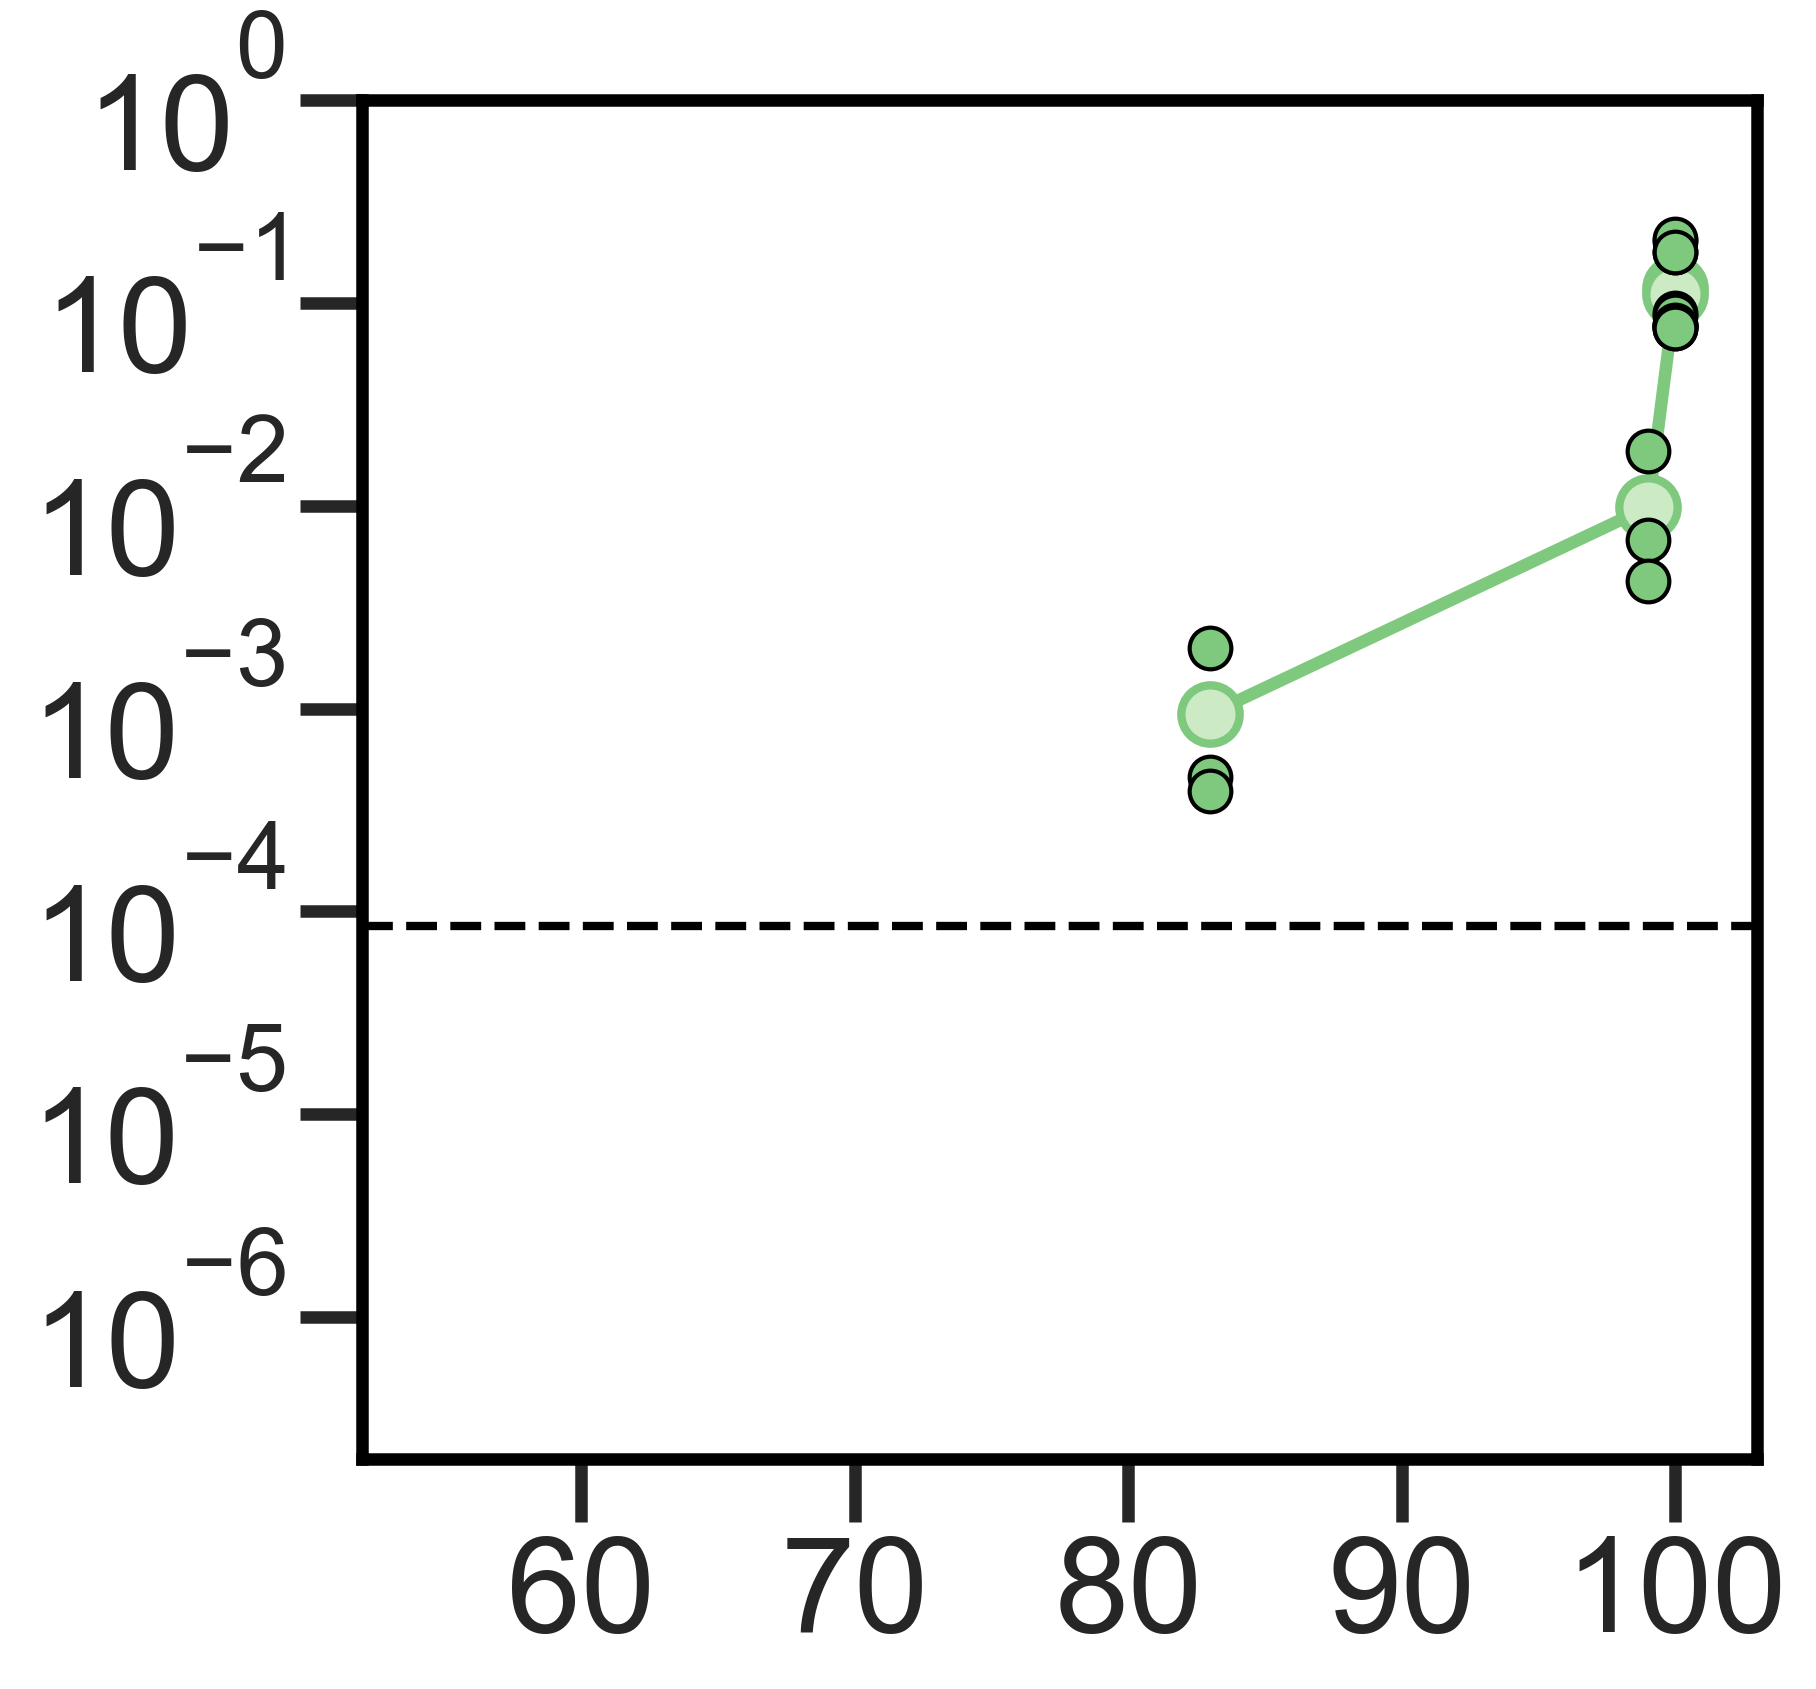

In [32]:
#for SEN4
x=[]
y=[]
x_means=[]
y_means=[]
E_x_neg=[]
E_y_neg=[]

for y_val in ['404', '404G', '404T']:
    x.append(100)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa1'].values))
    x.append(100)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa2'].values))
    x.append(100)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa3'].values))
    
    E_x_neg.append(100)
    E_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa1'].values))
    E_x_neg.append(100)
    E_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa2'].values))
    E_x_neg.append(100)
    E_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa3'].values))

x_means.append(100)
y_means.append((1/3)*(float(fracs2.loc[fracs2['sample']=='404_1', 'fa_mean'].values)
                      +float(fracs2.loc[fracs2['sample']=='404G_1', 'fa_mean'].values)
                      +float(fracs2.loc[fracs2['sample']=='404T_1', 'fa_mean'].values)))

for x_val, y_val in zip([100,99,83], ['404', '577', '578']):
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa1'].values))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa2'].values))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa3'].values))
    x_means.append(x_val)
    y_means.append(float(fracs2.loc[fracs2['sample']==y_val+'_1', 'fa_mean'].values))
    
    E_x_neg.append(x_val)
    E_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa1'].values))
    E_x_neg.append(x_val)
    E_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa2'].values))
    E_x_neg.append(x_val)
    E_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa3'].values))


fig, ax=plt.subplots(figsize=(6,6), dpi=300)


# ax.plot(x_neg_means, y_neg_means, '-o', color='#333333', mfc='grey', ms=10, lw=3, mew=2)
# ax.plot(52*np.ones(len(E_y_neg)), E_y_neg, 'o', color='grey', ms=10, mec='black')
ax.plot([52, 103], [np.mean(E_y_neg), np.mean(E_y_neg)], '--', color='black', lw=2)

ax.plot(x_means, y_means, '-o', color=darks[3], mfc=pastels[3], ms=14, lw=3, mew=2)
ax.plot(x, y, 'o', color=darks[3], ms=10, mec='black')
        
        

ax.grid(False)
ax.set_yscale('log')
ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_ylim(2e-7, 1e0)
ax.set_xticks([60, 70, 80, 90, 100])
ax.set_xlim(52, 103)
ax.tick_params(which='major', direction='out', length=15, width=3)
ax.tick_params(which='minor', direction='out', length=0, width=1)
ax.tick_params(axis='both', which='major', labelsize=32)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('black')


plt.show()
plt.tight_layout()
# fig.savefig(output+'/E_homologs_fit2.pdf', bbox_inches='tight')
plt.close()


 final_simplex: (array([[7.65130845e-01, 4.32819254e+03],
       [7.65130853e-01, 4.32819259e+03],
       [7.65130858e-01, 4.32819262e+03]]), array([0.22791461, 0.22791461, 0.22791461]))
           fun: 0.2279146062514628
       message: 'Optimization terminated successfully.'
          nfev: 145
           nit: 74
        status: 0
       success: True
             x: array([7.65130845e-01, 4.32819254e+03])
 final_simplex: (array([[6.53871530e-01, 3.07143544e+03],
       [6.53871518e-01, 3.07143536e+03],
       [6.53871535e-01, 3.07143545e+03]]), array([0.20255477, 0.20255477, 0.20255477]))
           fun: 0.20255476700831904
       message: 'Optimization terminated successfully.'
          nfev: 141
           nit: 71
        status: 0
       success: True
             x: array([6.53871530e-01, 3.07143544e+03])
 final_simplex: (array([[2.44355961e+00, 1.34061292e+04],
       [2.44355961e+00, 1.34061292e+04],
       [2.44355963e+00, 1.34061293e+04]]), array([0.26495392, 0.26495392, 0.

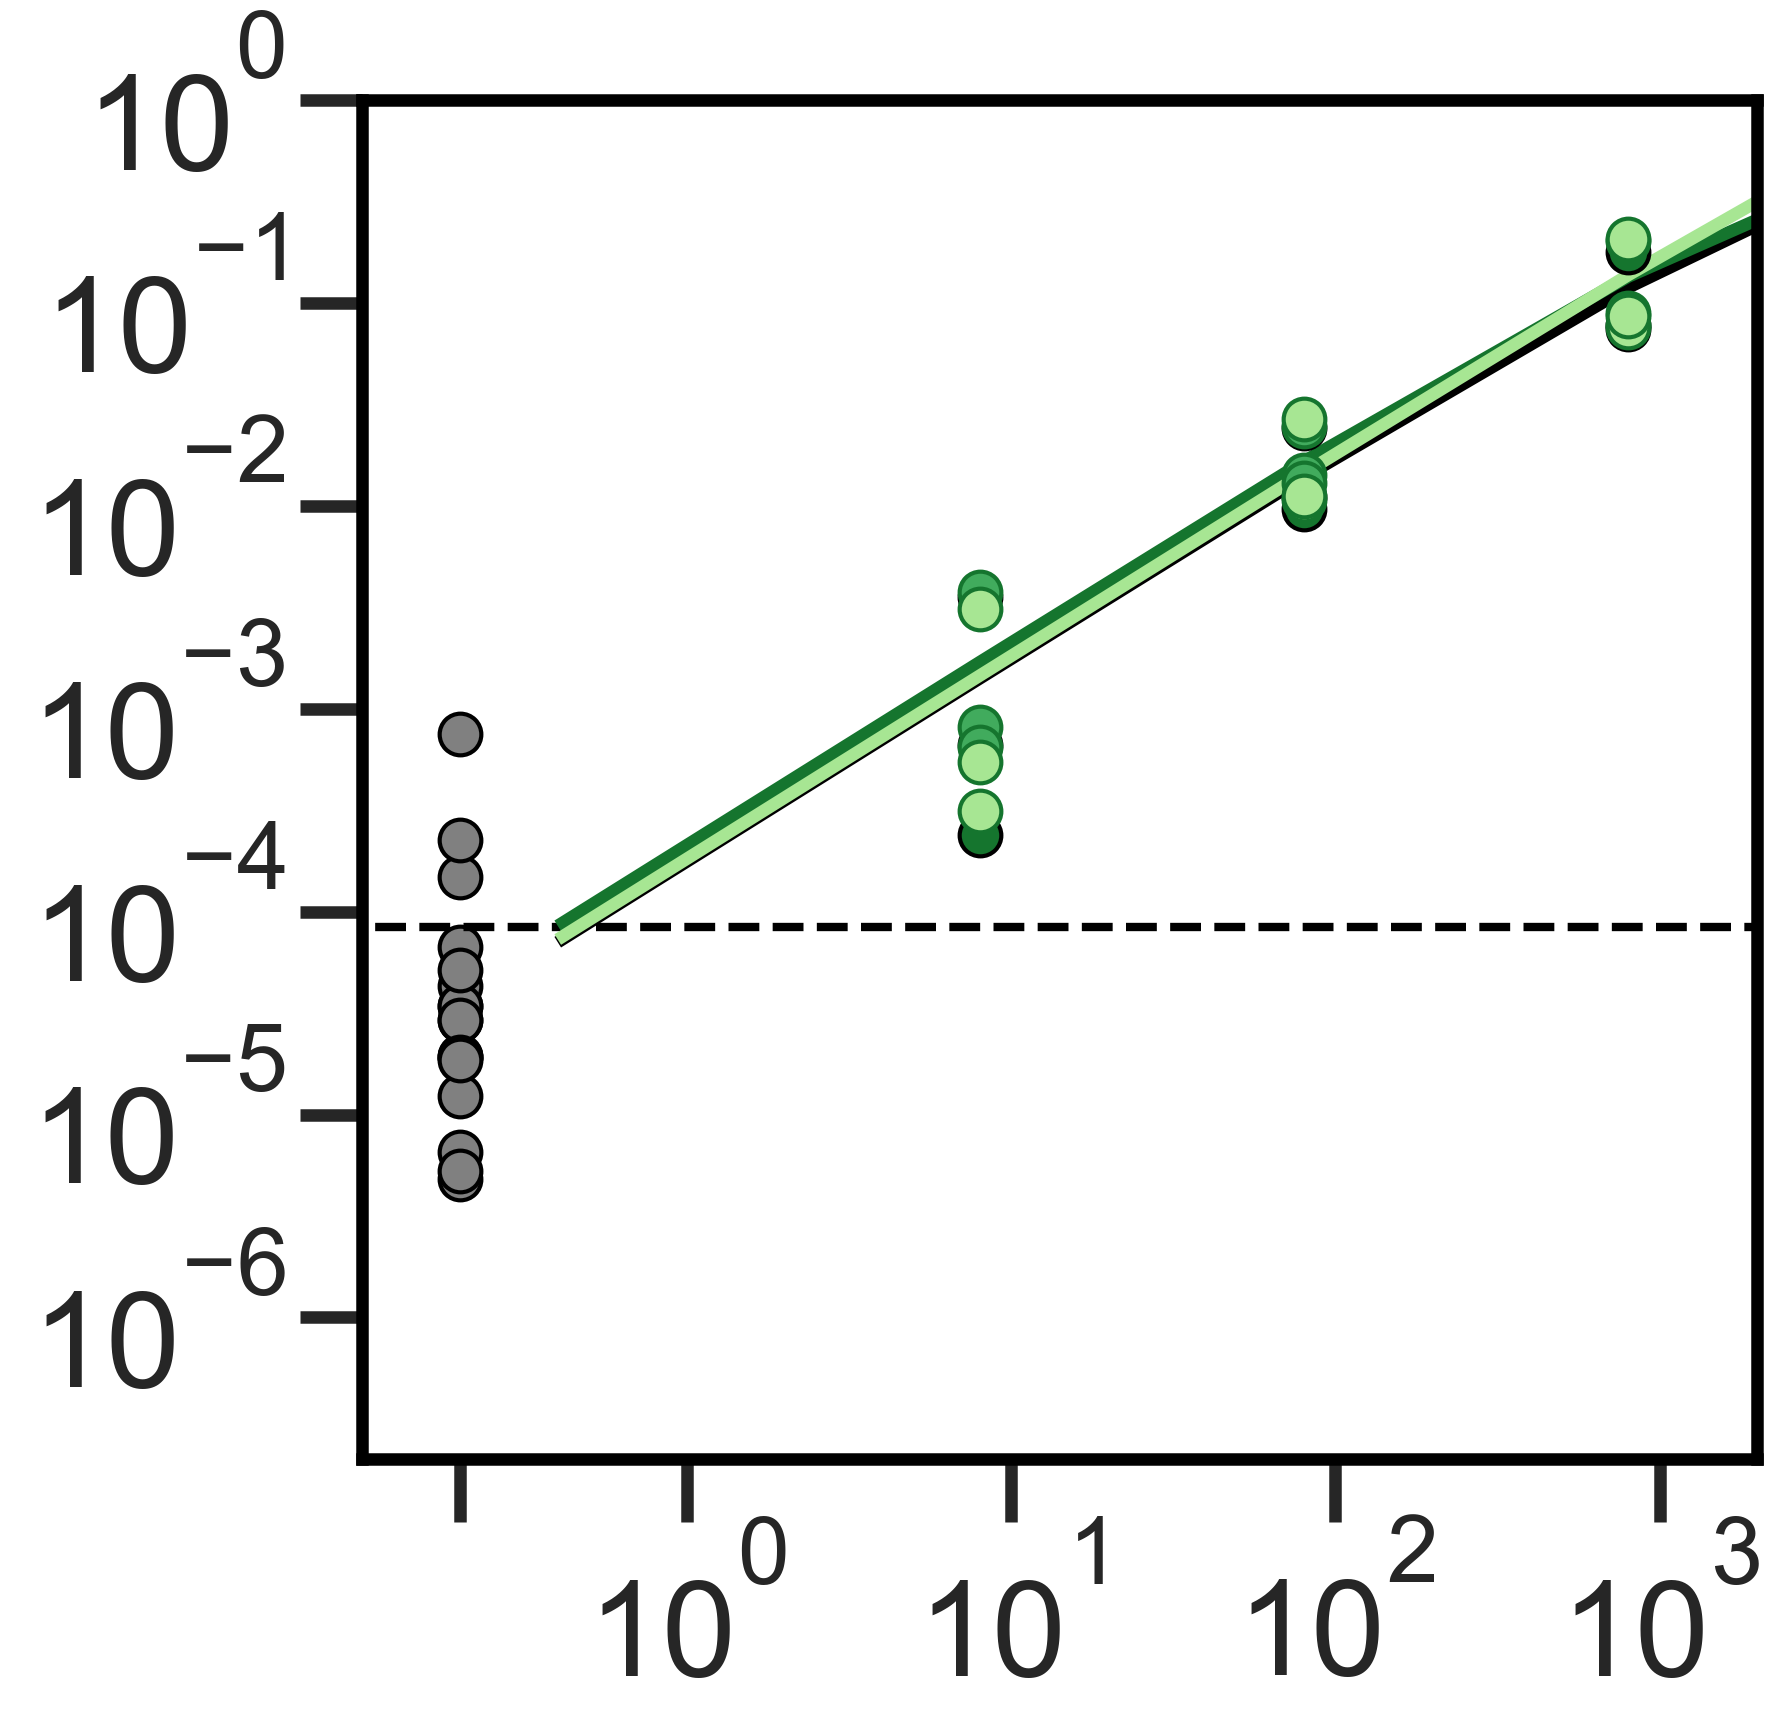

In [39]:

x=[]
y=[]
x_means=[]
y_means=[]

x2=[]
y2=[]
x2_means=[]
y2_means=[]

x3=[]
y3=[]
x3_means=[]
y3_means=[]



for x_val, y_val in zip([800, 80, 8], ['_1', '_2', '_3']):
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='404'+y_val, 'fa1']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='404'+y_val, 'fa2']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='404'+y_val, 'fa3']))
    x_means.append(x_val)
    y_means.append(float(fracs2.loc[fracs2['sample']=='404'+y_val, 'fa_mean']))
    
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='404G'+y_val, 'fa1']))
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='404G'+y_val, 'fa2']))
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='404G'+y_val, 'fa3']))
    x2_means.append(x_val)
    y2_means.append(float(fracs2.loc[fracs2['sample']=='404G'+y_val, 'fa_mean']))
    
    x3.append(x_val)
    y3.append(float(fracs2.loc[fracs2['sample']=='404T'+y_val, 'fa1']))
    x3.append(x_val)
    y3.append(float(fracs2.loc[fracs2['sample']=='404T'+y_val, 'fa2']))
    x3.append(x_val)
    y3.append(float(fracs2.loc[fracs2['sample']=='404T'+y_val, 'fa3']))
    x3_means.append(x_val)
    y3_means.append(float(fracs2.loc[fracs2['sample']=='404T'+y_val, 'fa_mean']))


    
xlog=np.log(x)
ylog=np.log(y)
x2log=np.log(x2)
y2log=np.log(y2)
x3log=np.log(x3)
y3log=np.log(y3)

p0=[.7, 1000]

#minimize log transformed l2 cost fxn
output1=minimize(test_l2_cost_fxn, p0, args=(xlog, ylog), method='Nelder-mead')
params1=output1.x
print(output1)

output2=minimize(test_l2_cost_fxn, p0, args=(x2log, y2log), method='Nelder-mead')
params2=output2.x
print(output2)

output3=minimize(test_l2_cost_fxn, p0, args=(x3log, y3log), method='Nelder-mead')
params3=output3.x
print(output3)

    
    
fig, ax=plt.subplots(figsize=(6,6), dpi=300)
# ax.plot(x_neg_means, y_neg_means, '-o', color='#333333', mfc='grey', ms=10, lw=3, mew=2)
ax.plot(.2*np.ones(len(E_y_neg)), E_y_neg, 'o', color='grey', ms=10, mec='black')
ax.plot([.08,2000], [np.mean(E_y_neg), np.mean(E_y_neg)], '--', color='black', lw=2)

ax.plot([.4, 8, 80, 800, 2000], fit_fxn(np.array([.4, 8, 80, 800, 2000]), *params1), '-', color='black', lw=3, solid_capstyle='butt')

ax.plot([.4, 8, 80, 800,2000], fit_fxn(np.array([.4, 8, 80, 800, 2000]), *params2), '-', color='#15752E', lw=3, solid_capstyle='butt')                   

ax.plot([.4, 8, 80, 800,2000], fit_fxn(np.array([.4, 8, 80, 800, 2000]), *params3), '-', color='#A7E693', lw=3, solid_capstyle='butt')                   

# ax.plot(x_means, y_means, '-', color='black', mfc=pastels[0], ms=14, lw=3, mew=2, solid_capstyle='butt')
ax.plot(x, y, 'o', color='#15752E', ms=10, mec='black')
# ax.plot(x2_means, y2_means, '-', color='#15752E', mfc=pastels[3], ms=14, lw=3, mew=2, solid_capstyle='butt')
ax.plot(x2, y2, 'o', color='#41AB5D', ms=10, mec='#15752E')
# ax.plot(x3_means, y3_means, '-', color='#A7E693', mfc=pastels[3], ms=14, lw=3, mew=2, solid_capstyle='butt')
ax.plot(x3, y3, 'o', color='#A7E693', ms=10, mec='#15752E')
    
        

ax.grid(False)
ax.set_yscale('log')
ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_ylim(2e-7, 1e0)
ax.set_xscale('log')
ax.set_xticks([.2, 1e0, 1e1, 1e2, 1e3])
ax.set_xlim(.1, 2000)
ax.tick_params(which='major', direction='out', length=15, width=3)
ax.tick_params(which='minor', direction='out', length=0, width=1)
ax.tick_params(axis='both', which='major', labelsize=32)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('black')


plt.show()
# plt.tight_layout()
# fig.savefig(output+'/E_concen_fit2.pdf', bbox_inches='tight')
plt.close()

 final_simplex: (array([[7.01910787e-01, 9.59151544e+02],
       [7.01910732e-01, 9.59151457e+02],
       [7.01910761e-01, 9.59151473e+02]]), array([0.42536785, 0.42536785, 0.42536785]))
           fun: 0.4253678460284722
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 49
        status: 0
       success: True
             x: array([7.01910787e-01, 9.59151544e+02])
 final_simplex: (array([[  0.7582291 , 750.42642308],
       [  0.75822913, 750.42649826],
       [  0.75822908, 750.42641329]]), array([0.7672928, 0.7672928, 0.7672928]))
           fun: 0.7672928000594782
       message: 'Optimization terminated successfully.'
          nfev: 118
           nit: 61
        status: 0
       success: True
             x: array([  0.7582291 , 750.42642308])


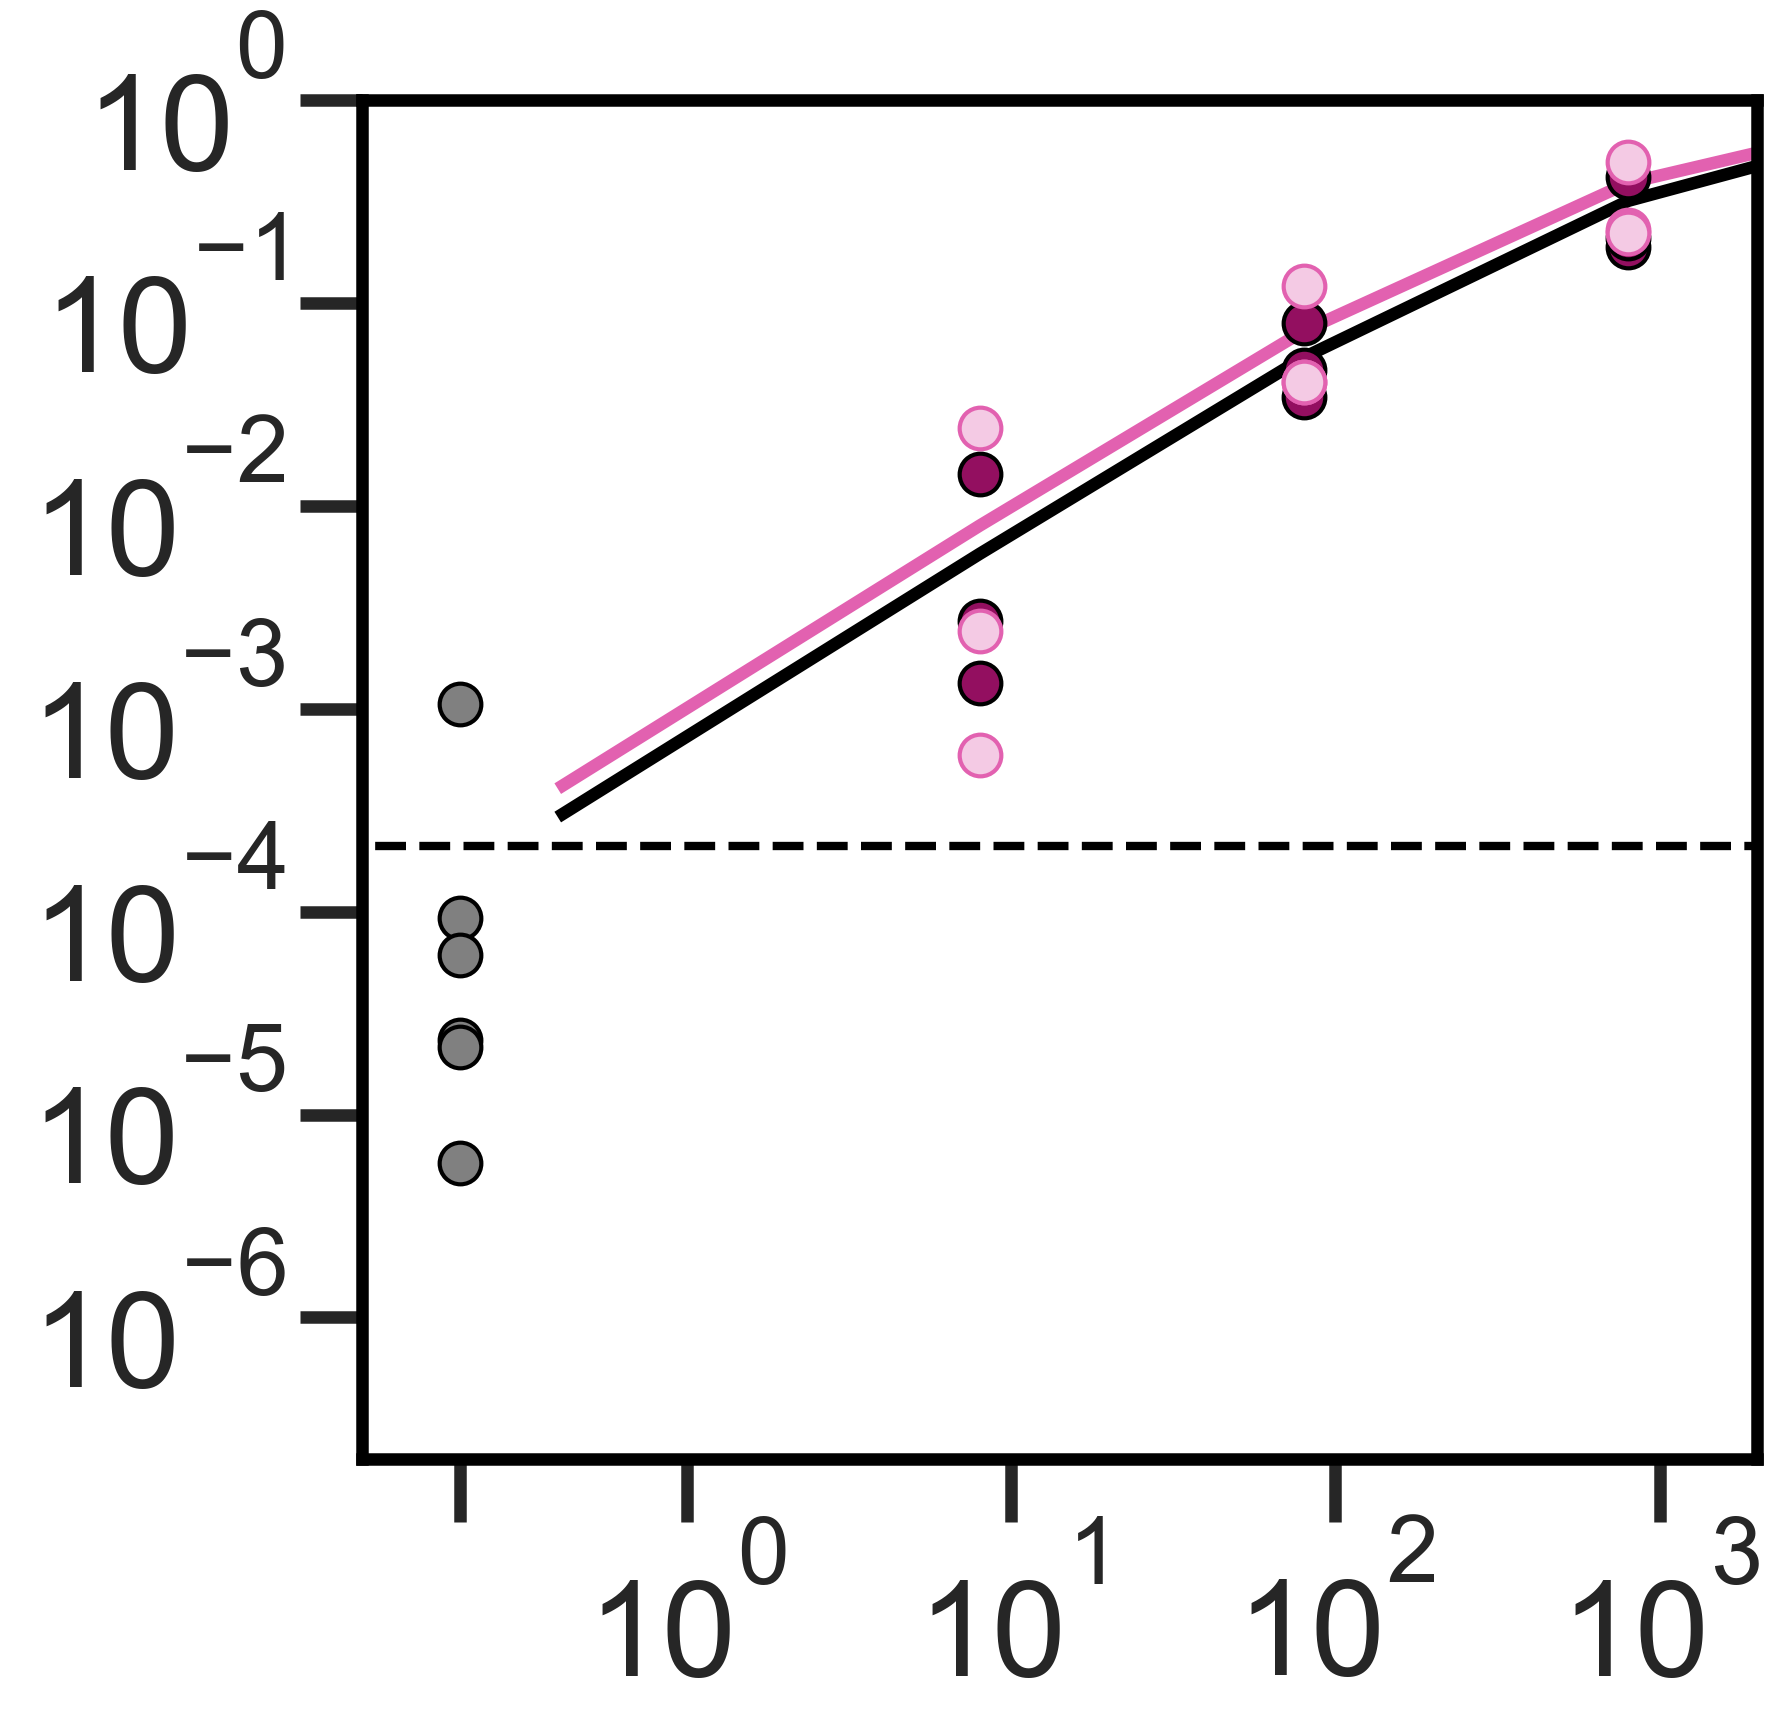

In [40]:
# for SEN5

x=[]
y=[]
x_means=[]
y_means=[]

x2=[]
y2=[]
x2_means=[]
y2_means=[]



F_x_neg=[]
F_y_neg=[]

for y_val in ['405', '405A']:

    F_x_neg.append(100)
    F_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa1']))
    F_x_neg.append(100)
    F_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa2']))
    F_x_neg.append(100)
    F_y_neg.append(float(fracs2.loc[fracs2['sample']==y_val+'_4', 'fa3']))

for x_val, y_val in zip([800, 80, 8], ['_1', '_2', '_3']):
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='405'+y_val, 'fa1']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='405'+y_val, 'fa2']))
    x.append(x_val)
    y.append(float(fracs2.loc[fracs2['sample']=='405'+y_val, 'fa3']))
    x_means.append(x_val)
    y_means.append(float(fracs2.loc[fracs2['sample']=='405'+y_val, 'fa_mean']))
    
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='405A'+y_val, 'fa1']))
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='405A'+y_val, 'fa2']))
    x2.append(x_val)
    y2.append(float(fracs2.loc[fracs2['sample']=='405A'+y_val, 'fa3']))
    x2_means.append(x_val)
    y2_means.append(float(fracs2.loc[fracs2['sample']=='405A'+y_val, 'fa_mean']))
    

xlog=np.log(x)
ylog=np.log(y)
x2log=np.log(x2)
y2log=np.log(y2)

p0=[.7, 1000]

#minimize log transformed l2 cost fxn
output1=minimize(test_l2_cost_fxn, p0, args=(xlog, ylog), method='Nelder-mead')
params1=output1.x
print(output1)

output2=minimize(test_l2_cost_fxn, p0, args=(x2log, y2log), method='Nelder-mead')
params2=output2.x
print(output2)




fig, ax=plt.subplots(figsize=(6,6), dpi=300)
# ax.plot(x_neg_means, y_neg_means, '-o', color='#333333', mfc='grey', ms=10, lw=3, mew=2)
ax.plot(.2*np.ones(len(F_y_neg)), F_y_neg, 'o', color='grey', ms=10, mec='black')
ax.plot([.08,2000], [np.mean(F_y_neg), np.mean(F_y_neg)], '--', color='black', lw=2)


ax.plot([.4, 8, 80, 800, 2000], fit_fxn(np.array([.4, 8, 80, 800, 2000]), *params1), '-', color='black', lw=3, solid_capstyle='butt')

ax.plot([.4, 8, 80, 800,2000], fit_fxn(np.array([.4, 8, 80, 800, 2000]), *params2), '-', color=darks[4], lw=3, solid_capstyle='butt')                   

# ax.plot(x_means, y_means, '-', color='#930F60', mfc=pastels[0], ms=14, lw=3, mew=2, solid_capstyle='butt')
ax.plot(x, y, 'o', color='#930F60', ms=10, mec='black')
# ax.plot(x2_means, y2_means, '-', color='#EA93C8', mfc=pastels[3], ms=14, lw=3, mew=2, solid_capstyle='butt')
ax.plot(x2, y2, 'o', color=pastels[4], ms=10, mec=darks[4])

ax.grid(False)
ax.set_yscale('log')
ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_ylim(2e-7, 1e0)
ax.set_xscale('log')
ax.set_xticks([.2, 1e0, 1e1, 1e2, 1e3])
ax.set_xlim(.1, 2000)
ax.tick_params(which='major', direction='out', length=15, width=3)
ax.tick_params(which='minor', direction='out', length=0, width=1)
ax.tick_params(axis='both', which='major', labelsize=32)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('black')


plt.show()
plt.tight_layout()
# fig.savefig(output+'/A_concen_fit2.pdf', bbox_inches='tight')
plt.close()